In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.metrics import mean_squared_error, r2_score

import cvxpy as cvx

import pandas_datareader.data as web
import datetime

# Library with returns forecasting models
from PredictionModels2 import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions

In [5]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=176891a9a7b99a3de0e2779fa556bc54599447654829f1005b752c8b818908dd
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [7]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 9.8 MB/s eta 0:00:00


Setting the data parameters

In [176]:
tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

Determining the Markowitz model

In [177]:
class Markowitz(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps = caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)
        self.exp_returns = self.data[1].mean() * 252 # If we have daily data
        self.cov = self.data[1].cov() * 252
        self.length = self.exp_returns.shape[0]
    def optimize(self):
        """
        The function optimizes the weights using Markowitz approach
        The function returns optimized weights for Markowitz portfolio
        """
        Q = np.array(self.cov)
        q = np.array(self.exp_returns)
        # Inequalities are written as Gx <= h
        G = np.diag(-1*np.ones(self.length), 0)
        h = np.zeros(self.length, dtype=int)
        # Equality constraints are written as Ax == b
        A = np.ones(self.length, dtype=int)
        b = np.array([1])
        # Defining and solving the quandratic problem
        x = cvx.Variable(self.length)
        prob = cvx.Problem(cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x),
            [G @ x <= h, A @ x == b])
        prob.solve()

        # Retrieving the weights
        x_values = x.value
        w = dict()
        for i in range(self.length):
            w[self.tickers[i]] = round(x_values[i], 4)

        return w

    def plot_weights(self):
        weights = self.optimize()
        fig = plt.figure(figsize=(15,5))
        plt.bar(weights.keys(), weights.values(), color='b', width=0.7)
        plt.title("Asset allocation by Markowitz model", y=1.05)
        plt.xlabel("Investment assets")
        plt.ylabel("Weights of assets in Markowitz portfolio")
        plt.grid()
        plt.show()


[*********************100%***********************]  11 of 11 completed


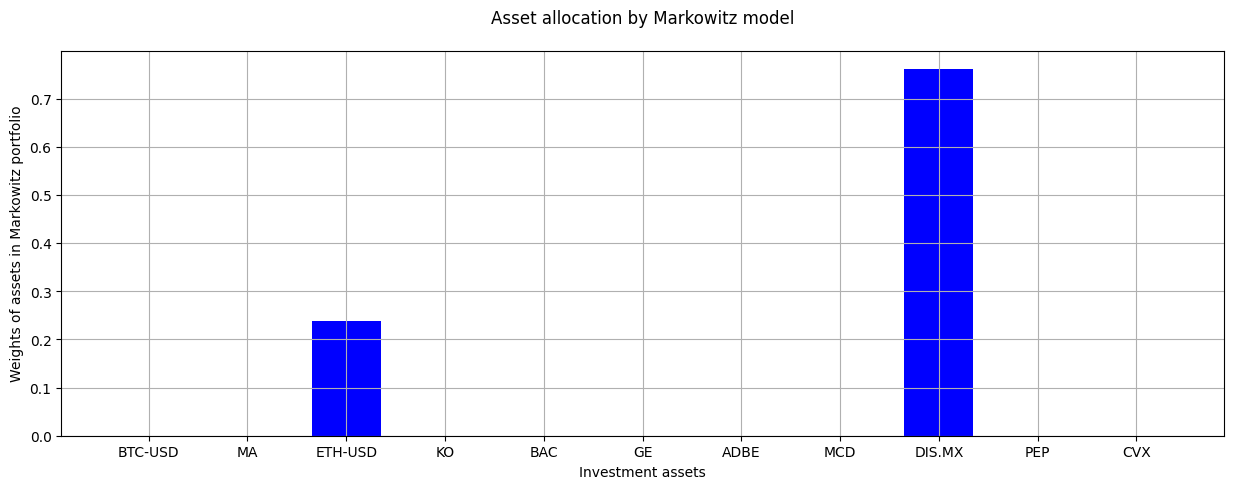

In [178]:
markowitz_model = Markowitz(tickers=tickers, start_date=start_date, end_date=end_date, period=period, caps=caps)
opt_weights = markowitz_model.optimize()
markowitz_model.plot_weights()

Black-Litterman model

In [179]:
class BlackLitterman(DataStore):
    def __init__(self, tickers=[], start_date = '2010-01-01', end_date = '2025-04-20', period = '1d', caps=caps):
        super().__init__(tickers, start_date, end_date, period, caps=caps)

        # Loading additional data of 3-month US treasure rates to calculate excess returns
        self.tickers = tickers
        self.start_date = start_date
        self.end_data = end_date
        self.t_rates = web.DataReader("TB3MS", 'fred', start=self.start_date, end=self.end_date)
        self.t_rates.reset_index(inplace=True)
        self.t_rates.rename(columns={"DATE": "Date"}, inplace=True)
        self.t_rates['TB3MS'] = self.t_rates['TB3MS'] / 100
        self.data[1].reset_index(inplace=True)
        print(self.data[1])

        # Merging the assets data and T-bill data
        self.full_data = pd.merge(self.data[1], self.t_rates, how='left', on='Date')
        # Filling in the gaps
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
        self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(0.0015)
        # Converting the rates into 1 day rate by dividing by 90 days
        self.full_data['TB3MS'] = self.full_data['TB3MS'] / 90

        # Dividing the data into treasury returns and other assets returns
        self.assets_returns = self.full_data[self.tickers]
        self.treasury_rate = self.full_data["TB3MS"]

    def equil_weights(self):
        """
            The function returns equilibrium weights calculated using market capitalization of assets (Yahoo Finance)
        """
        asset_weights = pd.DataFrame(self.caps.values(), index=self.caps.keys(), columns=['Cap'])
        asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
        return asset_weights

    def implied_equil_returns(self):
        """

        """
        assets_weights = self.equil_weights()
        excess_returns = self.assets_returns.subtract(self.treasury_rate, axis=0)
        # Calculation of excess returns covariance matrix
        covar = excess_returns.cov() * 252
                # Risk-aversion parameter
        risk_aversion = 10
        print("risk_aversion=",risk_aversion)

        return self.implied_function(risk_aversion, covar, assets_weights['Weights'])


    def implied_function(self, risk_avers_param, sig, weights):
        """
            The function calculates equlibrium market returns

            Arg:
                - risk_avers_param (float) - risk-aversion parameter
                - sig (np.array) - covariance matrix of excess returns
                - weights (pd.Series) - equilibrium market weights
            return: equlibrium market returns
        """

        return risk_avers_param * sig.dot(weights).squeeze()


    def views_function(self):
        pass

    def function(self, predictions: dict, method: str):
        """
        The function returns the views matrix based on predictions
        """
        pass


    def function1(self):
        """
        The function does some!
        """

        pass


    def consolid_preds(self):
        """
        The function stores expected returns for each asset based on different models predictions
        """
        self.q_matrix = np.zeros(len(self.tickers))

        # Container of forecasts
        preds = np.zeros((3, len(self.tickers)))

        for i, ticker in enumerate(self.tickers):
            # Initializing the prediction models

            # DesicionTreeRegressor
            des_tree = DesicionTreeRegressorPredictor(
                ticker=ticker,
                start_date=self.start_date, # At this point I set start_date at default (dynamicaly it will differ or will be fixed)
                end_date=self.end_date,     # At this point I set end_date at default (dynamicaly it will differ)
                features_target=self.features_target
            )
            # LogisticRegression
            log_reg = LinearRegressionPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )

            svr_reg = SVRPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )


            lstm_reg = LSTMPredictor(
                ticker=ticker,
                start_date=self.start_date,
                end_date=self.end_date,
                features_target=self.features_target
            )




            # Making forecasts
            preds[0, i] = des_tree.make_forecast()[0]
            preds[1, i] = log_reg.make_forecast()[0]
            preds[2, i] = svr_reg.make_forecast()[0]
            # preds[3, i] = lstm_reg.make_forecast()[0]




        return preds



In [180]:
# Checking the process
# bl = BlackLitterman(tickers, start_date, end_date, period)
# w = bl.implied_equil_returns()
# w

In [181]:
# tickers=[]
# start_date = '2010-01-01'
# end_date = '2025-04-20'
# period = '1d'
# t_rates = web.DataReader("TB3MS", 'fred', start=start_date, end=end_date)
# t_rates.reset_index(inplace=True)
# t_rates.rename(columns={"DATE": "Date"}, inplace=True)
# t_rates['TB3MS'] = t_rates['TB3MS'] / 100


# full_data = t_rates

# full_data['TB3MS'] = full_data['TB3MS'].fillna(method="ffill")
# full_data['TB3MS'] = full_data['TB3MS'].fillna(0.0015)
# full_data['TB3MS'] = full_data['TB3MS'] / 90

# assets_returns = full_data[tickers]
# treasury_rate = full_data["TB3MS"]


# asset_weights = pd.DataFrame(caps.values(), index=caps.keys(), columns=['Cap'])
# asset_weights['Weights'] = asset_weights['Cap'].apply(lambda x: x / asset_weights['Cap'].sum())
# assets_returns = full_data[tickers]
# excess_returns = assets_returns.subtract(treasury_rate, axis=0)

# covar = excess_returns.cov() * 252
#         # Risk-aversion parameter
# risk_aversion = 2.95

# prior = risk_aversion * covar.dot(asset_weights['Weights']).squeeze()

In [251]:
tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]

# Market capitalization in $Bln
caps = {
    'BTC-USD': 2101,
    'MA': 532,
    'ETH-USD': 307,
    'KO': 309,
    'BAC': 337,
    'GE': 250,
    'ADBE': 179,
    'MCD': 227,
    'DIS.MX': 202,
    'PEP': 180,
    'CVX': 239
}
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'

bl = BlackLitterman(tickers, start_date, end_date, period)

forecasts = bl.consolid_preds()
mean_preds = forecasts.mean(axis=0)
Q = pd.Series(mean_preds, index=tickers)

Q = Q * 0.5


P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


S           = bl.assets_returns.cov() * 252
prior       = bl.implied_equil_returns()   # π
confidences = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]






# Creating model
bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


rets = bl2.bl_returns() # Calculating Expected returns
ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
weights1 = ef.clean_weights() # Cleaning weights
weights1 # Printing weights

[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-01-03  0.018621 -0.003350  0.014505  0.007263  0.005248  0.084803   
1      2018-01-04  0.011970  0.013002  0.025858 -0.003117 -0.000692  0.018730   
2      2018-01-05  0.011504  0.004627  0.110945 -0.001641 -0.011604  0.016980   
3      2018-01-08 -0.001620 -0.006948 -0.138838  0.004913 -0.013631  0.140766   
4      2018-01-09  0.008931  0.004968 -0.038620 -0.005383  0.002835  0.123681   
...           ...       ...       ...       ...       ...       ...       ...   
1776   2025-04-10 -0.040835 -0.035620 -0.036352 -0.078685 -0.063141 -0.091283   
1777   2025-04-11  0.006890  0.002786  0.046364  0.004804  0.003068  0.028892   
1778   2025-04-14 -0.004436  0.019830  0.013547 -0.002288 -0.017067  0.034876   
1779   2025-04-15 -0.001511  0.035364 -0.010385 -0.005781  0.004095 -0.021261   
1780   2025-04-16 -0.017824 -0.017526  0.004351  0.006076 -0.034384 -0.006649   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


OrderedDict([('BTC-USD', 0.5),
             ('MA', 0.02),
             ('ETH-USD', 0.02),
             ('KO', 0.16406),
             ('BAC', 0.02),
             ('GE', 0.02),
             ('ADBE', 0.02),
             ('MCD', 0.05234),
             ('DIS.MX', 0.03963),
             ('PEP', 0.12397),
             ('CVX', 0.02)])

In [252]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]





# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


[*********************100%***********************]  11 of 11 completed
<ipython-input-252-e2a22a58dde3>:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio1 = (prices_portfolio1.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


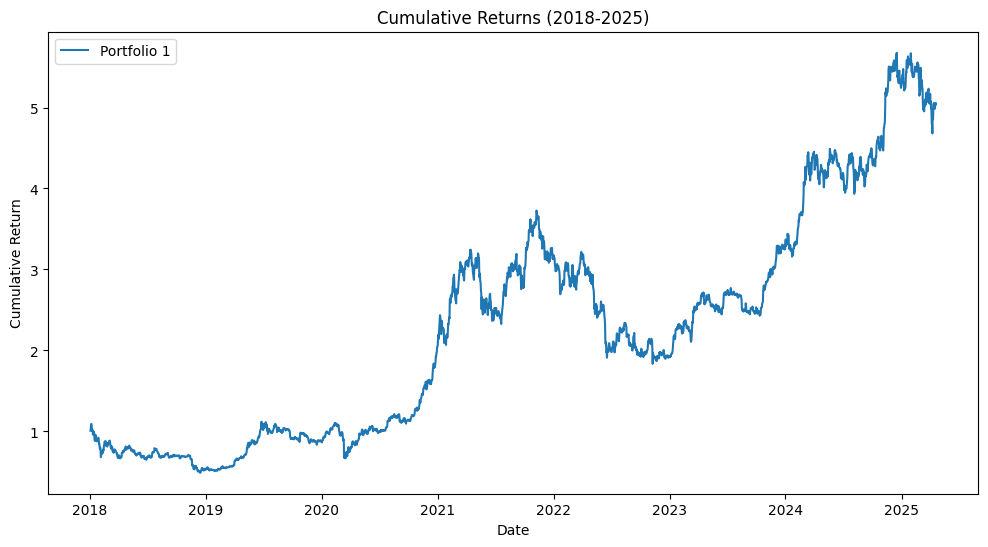

In [253]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Portfolio 1'] = (1 + returns_portfolio1).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [206]:
weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='3M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio = {}
returns_portfolio_2_ = {}
returns_portfolio_3_ = {}
returns_portfolio_4_ = {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs2 = [returns_portfolio[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# # Concatenate them side by side (columns)
combined_df2 = pd.concat(dfs2, axis=0)



#4 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='4M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}

for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)

dfs3 = [returns_portfolio_2_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df3 = pd.concat(dfs3, axis=0)



#5 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='5M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}

for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)




dfs4 = [returns_portfolio_3_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df4 = pd.concat(dfs4, axis=0)


#6 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='6M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs5 = [returns_portfolio_4_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df5 = pd.concat(dfs5, axis=0)


<ipython-input-206-c72e1b267d39>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(


2018-01-31 2018-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-02-01 -0.001904  0.015504 -0.108458  0.001754  0.020432 -0.075689   
1      2018-02-02 -0.018936 -0.017068 -0.037756 -0.057275 -0.019705 -0.124103   
2      2018-02-06 -0.005998 -0.023754 -0.130031 -0.011877 -0.024170 -0.143805   
3      2018-02-07 -0.011013  0.001602 -0.017262 -0.016260  0.007753 -0.046524   
4      2018-02-08 -0.038044 -0.049527  0.081154 -0.026277 -0.015427  0.077173   
5      2018-02-09  0.015168  0.019644  0.055464  0.010629 -0.013965  0.077678   
6      2018-02-12  0.021887  0.025713  0.021468  0.004220  0.005195 -0.017298   
7      2018-02-13  0.006898  0.001926 -0.037467 -0.006072  0.006713 -0.027364   
8      2018-02-14  0.018689  0.025959  0.099161  0.002997 -0.002190  0.088595   
9      2018-02-15  0.029195  0.006541  0.068362  0.000178  0.006247  0.014421   
10     2018-02-16 -0.006971 -0.007479  0.006618 -0.003471  0.009743  0.007691   
11     2018-02-20  0.007020 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2018-04-30 2018-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-05-02 -0.002259 -0.011429 -0.000501  0.003033  0.009950  0.025387   
1      2018-05-03  0.022141 -0.012930  0.053537  0.004135 -0.016914  0.126157   
2      2018-05-04  0.010824  0.003418 -0.004433 -0.003817  0.038687  0.007770   
3      2018-05-07  0.010794  0.011537 -0.034370 -0.004711  0.020913 -0.041451   
4      2018-05-08  0.015337  0.009737 -0.014853  0.012962  0.001400 -0.001152   
..            ...       ...       ...       ...       ...       ...       ...   
57     2018-07-24 -0.007660  0.002598  0.088455  0.020557 -0.018704  0.061338   
58     2018-07-25  0.021819  0.007754 -0.029255  0.008442 -0.019578 -0.014456   
59     2018-07-26 -0.004723 -0.004193 -0.028491 -0.007635 -0.014742 -0.018059   
60     2018-07-27 -0.027559  0.003871  0.026487  0.016166  0.035978  0.012058   
61     2018-07-30 -0.050259  0.008017  0.001893  0.014658 -0.003348 -0.027161   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2018-07-31 2018-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-08-01  0.013518  0.011911 -0.020192 -0.006993  0.000000 -0.030706   
1      2018-08-02  0.016833  0.000960 -0.007604 -0.013085  0.008588 -0.019502   
2      2018-08-03  0.004194  0.007326 -0.017700  0.002341  0.000000  0.013579   
3      2018-08-06  0.003272  0.000317 -0.067116  0.002013  0.019887 -0.028136   
4      2018-08-07 -0.002837 -0.000317 -0.028996  0.007055  0.006193 -0.067236   
..            ...       ...       ...       ...       ...       ...       ...   
59     2018-10-24 -0.054359 -0.031199  0.003099 -0.028534 -0.021881 -0.002371   
60     2018-10-25  0.058956  0.015157 -0.003014  0.012354 -0.003845 -0.005574   
61     2018-10-26 -0.028555 -0.007550 -0.000238 -0.000448 -0.001288  0.003005   
62     2018-10-29 -0.024921  0.008302 -0.022194 -0.023588  0.027455 -0.030369   
63     2018-10-30 -0.005605  0.006368  0.000259  0.017472  0.006425  0.001565   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*****************     36%                       ]  4 of 11 completed

2018-10-31 2019-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-11-01 -0.001955  0.011210  0.009479 -0.004308 -0.002574  0.007526   
1      2018-11-05 -0.022220  0.008949  0.006545  0.067559 -0.008901  0.050108   
2      2018-11-06  0.002789  0.005331  0.006420 -0.000336 -0.005101  0.043797   
3      2018-11-07  0.052118  0.011631  0.010643  0.016433  0.013143 -0.005826   
4      2018-11-08 -0.013787  0.011496 -0.011772 -0.012571  0.005086 -0.023065   
5      2018-11-09 -0.020696 -0.012198 -0.010608  0.001256  0.015972 -0.010215   
6      2018-11-12 -0.033938 -0.027370 -0.002250 -0.017899  0.003572  0.001636   
7      2018-11-13  0.008708  0.000360 -0.001851 -0.017531  0.004604 -0.017218   
8      2018-11-14 -0.014854 -0.020012 -0.102776  0.003203  0.002086 -0.131190   
9      2018-11-15  0.019909  0.025042 -0.015865  0.020299 -0.015960 -0.003263   
10     2018-11-16 -0.004427 -0.005391 -0.012916  0.017881 -0.005519 -0.031628   
11     2018-11-20 -0.083604 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-01-31 2019-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-02-01 -0.001777 -0.003166  0.008682  0.031931  0.000127  0.005113   
1      2019-02-05  0.029632  0.013996 -0.006209  0.009334  0.007417 -0.001546   
2      2019-02-06 -0.001846 -0.001739 -0.015288 -0.005035 -0.008015 -0.023774   
3      2019-02-07 -0.002401 -0.017203 -0.004197 -0.005483 -0.007084 -0.003667   
4      2019-02-08  0.012766  0.001769  0.075694 -0.005513  0.002367  0.131846   
5      2019-02-11  0.005394  0.004233 -0.005017 -0.005373  0.000000  0.016883   
6      2019-02-12  0.011467  0.009807  0.001396  0.015022 -0.007117  0.010447   
7      2019-02-13 -0.004371  0.000349 -0.005891  0.007134  0.018869 -0.000152   
8      2019-02-14 -0.000346 -0.010860 -0.004191 -0.001860 -0.001122 -0.009538   
9      2019-02-15 -0.002656  0.025045  0.001086  0.010021  0.014103  0.005833   
10     2019-02-19 -0.006341  0.000687  0.086282 -0.000335  0.000941  0.174275   
11     2019-02-20  0.001124 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2019-04-30 2019-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-05-02 -0.033788 -0.002620  0.028476 -0.031131 -0.012614 -0.000267   
1      2019-05-03  0.021019  0.006862  0.046667  0.007618 -0.009794  0.035327   
2      2019-05-06 -0.006746 -0.007846 -0.003731  0.009590  0.007843  0.027604   
3      2019-05-07 -0.023506 -0.018216  0.014287 -0.001099 -0.006270 -0.016672   
4      2019-05-08 -0.001083 -0.004019  0.025900 -0.006532  0.014679  0.006747   
..            ...       ...       ...       ...       ...       ...       ...   
57     2019-07-24  0.007733  0.013789 -0.009014  0.005706 -0.003527  0.020094   
58     2019-07-25 -0.004976 -0.010818  0.010132 -0.007217  0.005766  0.011779   
59     2019-07-26  0.008194  0.014073 -0.004200 -0.015320  0.013819  0.000053   
60     2019-07-29 -0.013097 -0.008158 -0.036226  0.004114  0.017522 -0.038815   
61     2019-07-30 -0.011721  0.012050  0.009231  0.000885 -0.013059 -0.003535   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-07-31 2019-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-08-01 -0.001406 -0.039560  0.030663 -0.019439  0.000366 -0.003875   
1      2019-08-02 -0.015976 -0.003737  0.011331 -0.000083  0.005113  0.000290   
2      2019-08-05 -0.046518 -0.045256  0.115474 -0.016621 -0.013327  0.072334   
3      2019-08-06  0.020651  0.012036 -0.028132  0.005376  0.025112 -0.035613   
4      2019-08-07  0.009770 -0.018825  0.039612 -0.002348 -0.047870  0.001637   
..            ...       ...       ...       ...       ...       ...       ...   
58     2019-10-24  0.031565 -0.001911 -0.002823 -0.003396 -0.004942 -0.001443   
59     2019-10-25  0.004735  0.011414  0.144761  0.009228  0.002050  0.112747   
60     2019-10-28  0.001364  0.003776  0.066492 -0.001602 -0.002110  0.006258   
61     2019-10-29  0.000368  0.007198  0.018363 -0.002958 -0.006018  0.041184   
62     2019-10-30  0.025317 -0.014131 -0.023825 -0.015097  0.004715 -0.030135   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-10-31 2020-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-11-01 -0.000396  0.016807  0.006665  0.000602  0.016551  0.000016   
1      2019-11-04 -0.001153  0.018692  0.016227  0.045091  0.003803  0.012882   
2      2019-11-05  0.041609  0.012880 -0.007474  0.003039 -0.000660  0.015701   
3      2019-11-06 -0.006555 -0.000915  0.001962 -0.016871 -0.011428  0.012023   
4      2019-11-07  0.011658  0.013329 -0.010019  0.016461  0.011993 -0.019061   
5      2019-11-08  0.005795  0.000902 -0.051214 -0.007907  0.032534 -0.020233   
6      2019-11-11 -0.007516 -0.002408 -0.005363 -0.000993 -0.006836  0.006915   
7      2019-11-12  0.004983 -0.002716  0.006587  0.001241  0.022741  0.007272   
8      2019-11-13  0.006220 -0.009108 -0.000840  0.010854  0.076047  0.007546   
9      2019-11-14  0.003367 -0.002749 -0.011437 -0.002620 -0.014812 -0.012073   
10     2019-11-15  0.010033  0.007009 -0.025129 -0.001077 -0.025250 -0.029897   
11     2019-11-19  0.010366 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2020-01-31 2020-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-02-04  0.043468  0.023778 -0.018301 -0.002710  0.035760  0.049226   
1      2020-02-05 -0.003250  0.031907  0.046028  0.031597 -0.030566  0.076176   
2      2020-02-06  0.005211 -0.001153  0.012033 -0.007189  0.017725  0.038936   
3      2020-02-07 -0.003735 -0.001732  0.006775 -0.005036 -0.009404  0.047758   
4      2020-02-10  0.010624  0.002309  0.006174  0.007772  0.008469  0.003570   
5      2020-02-11 -0.001948  0.002304  0.035052  0.012851 -0.015682  0.053688   
6      2020-02-12  0.013476  0.004305  0.011475  0.007435  0.004559  0.118060   
7      2020-02-13  0.001468 -0.000287 -0.010874 -0.003397 -0.004255  0.010096   
8      2020-02-14  0.012803 -0.001720  0.009523 -0.002631 -0.014224  0.058383   
9      2020-02-18 -0.002162 -0.016783 -0.016635  0.001453 -0.001716 -0.008029   
10     2020-02-19  0.011625  0.013045 -0.051450  0.004525  0.014946 -0.081937   
11     2020-02-20 -0.011335 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2020-04-30 2020-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-05-04 -0.012892 -0.047689  0.028924 -0.006106 -0.042742  0.002751   
1      2020-05-05  0.019909 -0.011845  0.010094  0.015733 -0.023760 -0.006746   
2      2020-05-06  0.017784 -0.013775  0.029084 -0.031051  0.014621 -0.013235   
3      2020-05-07  0.011683  0.021687  0.071075  0.028356  0.026222  0.039557   
4      2020-05-08  0.001988  0.031461 -0.010999  0.030091  0.019841  0.003302   
..            ...       ...       ...       ...       ...       ...       ...   
57     2020-07-24 -0.003318 -0.007773 -0.004622 -0.009716 -0.011523  0.016344   
58     2020-07-27  0.015656 -0.008662  0.141897  0.010046 -0.028381  0.141058   
59     2020-07-28 -0.011135  0.009073 -0.007127 -0.021427 -0.005735 -0.015221   
60     2020-07-29  0.009303  0.036676  0.017049  0.010715  0.002596  0.004831   
61     2020-07-30  0.005896 -0.017163  0.000968 -0.043105  0.007299  0.050244   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*****************     36%                       ]  4 of 11 completed

2020-07-31 2020-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-08-03  0.008181  0.004411 -0.006834  0.010311  0.017495  0.111451   
1      2020-08-04 -0.002347  0.000800 -0.003604  0.019615  0.015594  0.009226   
2      2020-08-05  0.005778  0.015080  0.047160  0.008176  0.064291  0.029606   
3      2020-08-06  0.031963  0.003146  0.002784  0.003092  0.030251 -0.016644   
4      2020-08-07 -0.031830  0.024817 -0.015252 -0.007689 -0.007106 -0.039901   
..            ...       ...       ...       ...       ...       ...       ...   
58     2020-10-26 -0.027604 -0.014563  0.011052 -0.022717 -0.032292 -0.039521   
59     2020-10-27  0.007046 -0.028520  0.043328 -0.020364 -0.002219  0.025340   
60     2020-10-28 -0.046164 -0.016061 -0.028446 -0.038571 -0.023634 -0.038726   
61     2020-10-29  0.009019  0.002978  0.012475  0.028304  0.029664 -0.004954   
62     2020-10-30 -0.030854  0.006774  0.008052  0.010123 -0.018372 -0.010162   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2020-10-31 2021-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-11-04  0.070595 -0.041768  0.013061  0.000418 -0.003519  0.036826   
1      2020-11-05  0.018787  0.038522  0.097416  0.005142 -0.002142  0.029223   
2      2020-11-06 -0.003713 -0.012265 -0.000897 -0.013818 -0.003741  0.093652   
3      2020-11-09 -0.048655  0.132708 -0.015119  0.109708  0.109226 -0.023489   
4      2020-11-10 -0.041473 -0.003609 -0.002705  0.045185 -0.010653  0.012344   
5      2020-11-11  0.034252 -0.011636  0.026488 -0.007370 -0.027583  0.029106   
6      2020-11-12 -0.011114 -0.024062  0.035967 -0.021947 -0.011154 -0.004232   
7      2020-11-13  0.014508  0.011548  0.002544  0.028836  0.017235  0.029119   
8      2020-11-17 -0.002966  0.020166  0.078218  0.061773  0.032852  0.012008   
9      2020-11-18 -0.018288 -0.020907  0.008948 -0.032223 -0.002979 -0.001825   
10     2020-11-19  0.014991  0.000000  0.000735  0.017058 -0.017976 -0.016515   
11     2020-11-20 -0.007511 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-01-31 2021-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-02-03 -0.006226  0.017569  0.053774  0.021589 -0.002766  0.091822   
1      2021-02-04  0.015361  0.028716 -0.014679  0.000449  0.024718 -0.040640   
2      2021-02-05  0.005583 -0.004008  0.032459  0.002917 -0.005862  0.074815   
3      2021-02-08  0.003327  0.021999  0.191527  0.024567  0.048936  0.016141   
4      2021-02-09  0.004627 -0.004240  0.006143 -0.005701 -0.008636  0.012188   
5      2021-02-10 -0.006837  0.000910 -0.034203  0.017005  0.004906 -0.013548   
6      2021-02-11  0.007986 -0.003037  0.064468 -0.005419 -0.000416  0.022424   
7      2021-02-12  0.004460  0.014793 -0.008478  0.005743 -0.014412  0.032939   
8      2021-02-16  0.005597  0.026613  0.035059  0.020284  0.001678 -0.034471   
9      2021-02-17 -0.020970  0.004077  0.058214  0.029518  0.006494  0.037139   
10     2021-02-18 -0.005839 -0.006414 -0.009038 -0.009638 -0.012116  0.047020   
11     2021-02-19 -0.019122 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2021-04-30 2021-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-05-03 -0.009646  0.000740 -0.009567  0.023587 -0.005063  0.212872   
1      2021-05-04 -0.025671  0.010790 -0.069994  0.005481 -0.003582 -0.053106   
2      2021-05-05 -0.008206  0.009467  0.073897  0.026505 -0.011794  0.079480   
3      2021-05-06 -0.006349  0.014868 -0.018055  0.000550 -0.015260 -0.009097   
4      2021-05-07  0.010531  0.004038  0.016877  0.009131  0.016653 -0.001764   
..            ...       ...       ...       ...       ...       ...       ...   
58     2021-07-26 -0.008134  0.011341  0.106022  0.020921  0.010442  0.049844   
59     2021-07-27 -0.004067 -0.003942  0.053943 -0.003374 -0.002846  0.028674   
60     2021-07-28  0.004261  0.003942  0.014835  0.005650 -0.002172 -0.000778   
61     2021-07-29  0.001255  0.014321  0.000313  0.013644 -0.003517  0.036096   
62     2021-07-30 -0.000113 -0.008307  0.054172 -0.007437 -0.015839  0.035485   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-07-31 2021-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-08-03  0.004081  0.015423 -0.027122  0.009499 -0.016380 -0.042179   
1      2021-08-04  0.007057 -0.007290  0.040943 -0.022672  0.000826  0.085099   
2      2021-08-05  0.010177  0.019408  0.027838  0.009229  0.020250  0.037003   
3      2021-08-06 -0.001108  0.028548  0.046538  0.007087  0.011606  0.022250   
4      2021-08-09 -0.003427  0.012868  0.079630 -0.016815 -0.000687  0.091473   
..            ...       ...       ...       ...       ...       ...       ...   
57     2021-10-25  0.005254 -0.001262  0.037950  0.009265  0.013903  0.060520   
58     2021-10-26 -0.006933  0.009427 -0.043377  0.002193  0.001854 -0.020788   
59     2021-10-27 -0.003774 -0.019369 -0.031664 -0.017952 -0.007986 -0.049839   
60     2021-10-28 -0.001251  0.015609  0.035934  0.009326  0.001226  0.086957   
61     2021-10-29  0.017183  0.000000  0.026144  0.012038  0.007053  0.029289   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-10-31 2022-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-11-03  0.023129  0.010809  0.031713 -0.013360 -0.009922  0.063293   
1      2021-11-04  0.028439 -0.021735 -0.024399  0.004414 -0.000711 -0.015282   
2      2021-11-05 -0.016996 -0.007635 -0.005328  0.010778  0.020927 -0.011322   
3      2021-11-08  0.004967  0.007846  0.100185  0.003567  0.005574  0.070115   
4      2021-11-09  0.002849 -0.009764 -0.008845  0.007354 -0.011069 -0.016135   
5      2021-11-10 -0.031050  0.007438 -0.029958 -0.016077  0.014740 -0.021107   
6      2021-11-11 -0.006710  0.005490 -0.000697  0.000087 -0.071029  0.020117   
7      2021-11-12  0.022188 -0.012288 -0.012300  0.000613 -0.023860 -0.013465   
8      2021-11-16  0.020217  0.003618 -0.064288  0.026350  0.005362 -0.101568   
9      2021-11-17 -0.000537 -0.012181  0.003431 -0.004495 -0.012546  0.016752   
10     2021-11-18  0.000432 -0.004093 -0.058424 -0.008440 -0.006887 -0.069269   
11     2021-11-19  0.025617 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2022-01-31 2022-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-02-01  0.003139  0.017190  0.006737  0.026005  0.010598  0.037899   
1      2022-02-02 -0.005406 -0.001066 -0.047311  0.004589 -0.011967 -0.039919   
2      2022-02-03 -0.042653 -0.009859  0.005441 -0.008976 -0.016975 -0.001377   
3      2022-02-04  0.005291  0.039072  0.110627  0.012441  0.020479  0.107622   
4      2022-02-08 -0.004352  0.022528  0.061163  0.004113  0.000095  0.045543   
5      2022-02-09  0.020212 -0.002027  0.004982  0.009846  0.023443  0.036737   
6      2022-02-10 -0.052590 -0.004678 -0.017603 -0.012782  0.037826 -0.051294   
7      2022-02-11 -0.043454 -0.023307 -0.026921  0.020157 -0.022181 -0.050003   
8      2022-02-14  0.000084 -0.010489  0.004212 -0.015537  0.008845  0.002080   
9      2022-02-15  0.011515  0.007772  0.045631 -0.007347  0.017636  0.080653   
10     2022-02-16 -0.003761 -0.002304 -0.013855  0.000298  0.009176 -0.016503   
11     2022-02-17 -0.042747 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2022-04-30 2022-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-05-03  0.000712  0.027025 -0.020422  0.017006 -0.009231 -0.026215   
1      2022-05-04  0.037962  0.039345  0.050313  0.030904  0.012018  0.054928   
2      2022-05-05 -0.055461 -0.028363 -0.081941 -0.007968 -0.025872 -0.067314   
3      2022-05-06 -0.024006 -0.002400 -0.014714  0.026296 -0.017658 -0.019924   
4      2022-05-09 -0.036727 -0.029262 -0.173608 -0.069374 -0.020865 -0.182493   
..            ...       ...       ...       ...       ...       ...       ...   
56     2022-07-25 -0.025044  0.008934 -0.061425  0.029318 -0.003907 -0.061721   
57     2022-07-26 -0.032938 -0.020366 -0.005725 -0.007843 -0.027029 -0.002478   
58     2022-07-27  0.035028  0.016207  0.076595  0.013082  0.030527  0.126499   
59     2022-07-28  0.026927 -0.008070  0.039058  0.007542  0.012604  0.053102   
60     2022-07-29  0.016273  0.014599 -0.001648  0.085292  0.012332  0.001123   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2022-07-31 2022-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-08-02 -0.002753 -0.020075 -0.014520 -0.008572  0.007922 -0.001377   
1      2022-08-03  0.034947  0.017997 -0.005744 -0.024039  0.024663 -0.008654   
2      2022-08-04  0.014150 -0.007160 -0.009480 -0.027538 -0.014526 -0.006612   
3      2022-08-05  0.006574  0.016627  0.028676  0.016406 -0.012020  0.074305   
4      2022-08-08  0.002097 -0.013936  0.022089 -0.001498  0.015153  0.024667   
..            ...       ...       ...       ...       ...       ...       ...   
57     2022-10-24  0.031645  0.003427  0.008988 -0.000346 -0.011835  0.034070   
58     2022-10-25  0.023657  0.009083  0.038050  0.010343  0.029824  0.083184   
59     2022-10-26 -0.010275  0.008721  0.033017  0.012272  0.014817  0.069310   
60     2022-10-27 -0.005727  0.004751 -0.023608  0.004564 -0.015251 -0.033884   
61     2022-10-28  0.021822  0.008605  0.015142  0.011624  0.007188  0.026780   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2022-10-31 2023-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-11-01 -0.007817  0.004430 -0.000512  0.007271 -0.010874  0.004435   
1      2022-11-03 -0.100058 -0.008601 -0.013529 -0.006000 -0.066748 -0.030963   
2      2022-11-04 -0.000630  0.024767  0.045332  0.012564 -0.007728  0.071522   
3      2022-11-07  0.047131  0.005962 -0.026081  0.011869  0.007185 -0.047619   
4      2022-11-08  0.008742  0.002699 -0.105429 -0.001456  0.000655 -0.162869   
5      2022-11-09 -0.010981 -0.016026 -0.154890 -0.040802 -0.141831 -0.191844   
6      2022-11-10  0.098932  0.043141  0.102037  0.018763  0.027599  0.166488   
7      2022-11-11  0.033381  0.007316 -0.031918  0.028064  0.059856 -0.009467   
8      2022-11-14 -0.002289 -0.017067 -0.024730  0.000483 -0.013642 -0.036081   
9      2022-11-15  0.016290 -0.001590  0.015904  0.008008  0.008335  0.008127   
10     2022-11-16 -0.022065 -0.009059 -0.012826 -0.016406 -0.015290 -0.029292   
11     2022-11-17 -0.001715 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*************         27%                       ]  3 of 11 completed

2023-01-31 2023-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-02-01  0.036013  0.012325  0.024946 -0.015403  0.002309  0.034236   
1      2023-02-02  0.021414  0.005829 -0.010675 -0.013809  0.034647  0.000882   
2      2023-02-03 -0.033442  0.008269 -0.000961  0.002600 -0.005771  0.013001   
3      2023-02-07  0.011767  0.009290 -0.007922  0.027014  0.007273  0.004350   
4      2023-02-08 -0.014328 -0.007370 -0.014064 -0.023774 -0.000734 -0.012813   
5      2023-02-09 -0.006762 -0.021602 -0.050073 -0.009219 -0.019756 -0.065255   
6      2023-02-10 -0.012909 -0.003927 -0.007723  0.020740 -0.029017 -0.020625   
7      2023-02-13  0.010751  0.001965  0.007221 -0.005598 -0.000637 -0.005098   
8      2023-02-14  0.007704 -0.000842  0.018747  0.007631 -0.006280  0.032450   
9      2023-02-15 -0.005200 -0.001686  0.089770 -0.010594  0.024990  0.072384   
10     2023-02-16 -0.029094 -0.007905 -0.028558 -0.014542 -0.040031 -0.020327   
11     2023-02-17 -0.023020 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2023-04-30 2023-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-05-03 -0.065606 -0.010711  0.011295 -0.020261  0.000050  0.017939   
1      2023-05-04 -0.027664 -0.031726 -0.005483 -0.003897 -0.035096 -0.014249   
2      2023-05-05  0.036746  0.026327  0.023525  0.025220  0.025242  0.060625   
3      2023-05-08 -0.012535 -0.000722 -0.064330 -0.003940  0.027460 -0.076007   
4      2023-05-09 -0.004107 -0.001084 -0.001283 -0.002887 -0.010936 -0.000238   
5      2023-05-10  0.003990 -0.012368 -0.001339 -0.012840 -0.021297 -0.003360   
6      2023-05-11 -0.007118  0.002559 -0.022738 -0.005554 -0.089404 -0.025235   
7      2023-05-12 -0.018109 -0.011013 -0.007278  0.002557 -0.006000  0.006397   
8      2023-05-15  0.030012  0.020461  0.014360  0.003697  0.001317  0.005257   
9      2023-05-16 -0.001621 -0.010543 -0.005755 -0.023753 -0.016892  0.003609   
10     2023-05-17  0.032836  0.043275  0.013306  0.014230  0.020548 -0.001241   
11     2023-05-18  0.010599 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-07-31 2023-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-08-01  0.005350 -0.011946  0.015130 -0.008345  0.010405  0.008385   
1      2023-08-02 -0.034838 -0.013692 -0.017808 -0.015962 -0.021396 -0.017626   
2      2023-08-03 -0.012409  0.007029  0.000916 -0.000376  0.007192 -0.002152   
3      2023-08-04  0.005939 -0.003508 -0.003591 -0.002257 -0.005566 -0.004053   
4      2023-08-07  0.005395  0.018361  0.003656  0.003634  0.000924 -0.000424   
..            ...       ...       ...       ...       ...       ...       ...   
59     2023-10-24 -0.001574 -0.003919  0.024343 -0.025401 -0.000007  0.010736   
60     2023-10-25 -0.034735  0.003136  0.017581 -0.004992 -0.020081  0.001657   
61     2023-10-26 -0.013251  0.022064 -0.010084 -0.007211 -0.020775  0.009268   
62     2023-10-27 -0.012050 -0.037049 -0.007253 -0.069570 -0.009232 -0.013389   
63     2023-10-30  0.036369  0.020449  0.017324  0.011982  0.009508  0.016737   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2023-10-31 2024-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-11-01  0.023112  0.002275  0.021953 -0.012081 -0.017033  0.016722   
1      2023-11-03  0.034583  0.073729 -0.020093  0.024899  0.032607 -0.007769   
2      2023-11-06  0.003171 -0.003172  0.008744 -0.004141 -0.013708  0.035926   
3      2023-11-07  0.034332 -0.006019  0.011526 -0.017776  0.002446 -0.006184   
4      2023-11-08  0.000188 -0.009634  0.005956 -0.014017  0.008373  0.000634   
5      2023-11-09 -0.013018 -0.012992  0.028692 -0.003236  0.078847  0.115462   
6      2023-11-10  0.033162  0.005434  0.016778  0.007091 -0.036635 -0.020135   
7      2023-11-13 -0.011587  0.000722 -0.021991  0.007318  0.009605 -0.011140   
8      2023-11-14  0.023422  0.053421 -0.026784  0.007265  0.010993 -0.037787   
9      2023-11-15 -0.015038  0.013596  0.063846  0.003510  0.026634  0.040286   
10     2023-11-16  0.011275 -0.002705 -0.046630 -0.015954 -0.001262 -0.049510   
11     2023-11-17  0.000996 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2024-01-31 2024-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-02-01  0.016264 -0.013618  0.011515  0.003115  0.005151  0.009280   
1      2024-02-02  0.010850 -0.002387  0.002552  0.028990 -0.000109  0.001827   
2      2024-02-06 -0.044488 -0.012931 -0.002346  0.000722  0.021866  0.027421   
3      2024-02-07  0.014244  0.004228  0.028229 -0.001445 -0.001916  0.021495   
4      2024-02-08  0.000016 -0.001810  0.021946  0.012607  0.112504 -0.001585   
5      2024-02-09  0.018262 -0.001511  0.039933 -0.019798 -0.023310  0.027556   
6      2024-02-12 -0.024811  0.016495  0.057913  0.006862  0.011289  0.066333   
7      2024-02-13 -0.016396 -0.026218 -0.004329 -0.009779  0.015895 -0.006011   
8      2024-02-14  0.004592  0.011536  0.041047  0.002719 -0.004176  0.050090   
9      2024-02-15 -0.023798  0.027978  0.002156  0.033442  0.007910  0.016592   
10     2024-02-16 -0.077041  0.000587  0.004258  0.001100 -0.004440 -0.007352   
11     2024-02-20 -0.008727 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2024-04-30 2024-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-05-02  0.029255 -0.003519 -0.025276 -0.003354  0.009121 -0.008039   
1      2024-05-03  0.019964  0.009983  0.061757 -0.002991  0.005929  0.037883   
2      2024-05-06  0.015126  0.011743  0.004317  0.012711  0.022767 -0.013238   
3      2024-05-07 -0.002678  0.003972 -0.013182  0.002277 -0.097978 -0.018504   
4      2024-05-08 -0.008507 -0.003441 -0.018570 -0.000799 -0.005144 -0.011010   
..            ...       ...       ...       ...       ...       ...       ...   
56     2024-07-24 -0.027800 -0.005201 -0.008462  0.006340 -0.004044 -0.042731   
57     2024-07-25  0.002088 -0.012162  0.006178  0.015803  0.000049 -0.049747   
58     2024-07-26  0.019152 -0.000240  0.031940  0.001903  0.006494  0.031481   
59     2024-07-29 -0.010806 -0.014017 -0.016213 -0.007887  0.041123  0.013519   
60     2024-07-30  0.003906  0.004613 -0.009305  0.018788  0.018833 -0.012690   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2024-07-31 2024-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-08-01 -0.009544 -0.020299  0.011360 -0.050156 -0.006166 -0.009244   
1      2024-08-02 -0.037745 -0.049829 -0.062217 -0.027030 -0.018584 -0.069700   
2      2024-08-05 -0.032548 -0.025059 -0.128829 -0.026535  0.005442 -0.211327   
3      2024-08-06  0.009536  0.007340  0.037138 -0.009935  0.025873  0.017030   
4      2024-08-07 -0.001129  0.010240 -0.018132 -0.005742 -0.060458 -0.050950   
..            ...       ...       ...       ...       ...       ...       ...   
57     2024-10-24 -0.004463  0.007295  0.025692 -0.000199 -0.009506  0.010072   
58     2024-10-25  0.001759 -0.017980 -0.022532  0.002390  0.004309 -0.039666   
59     2024-10-28 -0.005556  0.017276  0.047835 -0.001792  0.014577  0.051764   
60     2024-10-29  0.009002 -0.002114  0.039447 -0.013509  0.000000  0.027911   
61     2024-10-30  0.002654 -0.005186 -0.005252 -0.003170  0.001037  0.007333   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regr

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
<ipython-input-206-c72e1b267d39>:119: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(


2018-01-31 2018-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-02-01 -0.001904  0.015504 -0.108458  0.001753  0.020432 -0.075689   
1      2018-02-02 -0.018936 -0.017068 -0.037756 -0.057275 -0.019705 -0.124103   
2      2018-02-06 -0.005998 -0.023754 -0.130031 -0.011877 -0.024170 -0.143805   
3      2018-02-07 -0.011013  0.001601 -0.017262 -0.016260  0.007753 -0.046524   
4      2018-02-08 -0.038044 -0.049526  0.081154 -0.026277 -0.015427  0.077173   
..            ...       ...       ...       ...       ...       ...       ...   
73     2018-05-23  0.021215 -0.014675 -0.062068  0.003659 -0.025442 -0.104301   
74     2018-05-24  0.005071 -0.007585  0.003898 -0.016373 -0.004968  0.030660   
75     2018-05-25 -0.006507 -0.001656 -0.014230 -0.035534 -0.002992 -0.025279   
76     2018-05-29 -0.005641 -0.040601 -0.001010 -0.006569 -0.013325 -0.037059   
77     2018-05-30  0.021284  0.018136 -0.008881  0.030585 -0.002788 -0.010308   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2018-05-31 2018-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-06-01  0.008110  0.012320  0.006289 -0.003627 -0.002647  0.004143   
1      2018-06-04  0.008045  0.000000 -0.003584 -0.012921  0.012252  0.022067   
2      2018-06-05 -0.002529 -0.009569  0.015750  0.003837  0.017096  0.027147   
3      2018-06-06  0.004934  0.031105  0.002645  0.005282  0.013149 -0.003583   
4      2018-06-07 -0.025686  0.001663  0.003165  0.028603  0.016010 -0.003196   
..            ...       ...       ...       ...       ...       ...       ...   
79     2018-09-24  0.012229 -0.009390 -0.020936  0.012226  0.017031 -0.075160   
80     2018-09-25  0.014100 -0.002280 -0.022841  0.006098  0.000000 -0.045733   
81     2018-09-26  0.002349 -0.017764  0.007500 -0.011577  0.000000 -0.012239   
82     2018-09-27  0.005349 -0.006325  0.027599  0.004255  0.019641  0.056940   
83     2018-09-28  0.000148 -0.016162 -0.004898 -0.001553  0.001561 -0.027023   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2018-09-30 2019-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-10-02 -0.012749 -0.002364 -0.005100  0.002810  0.012373 -0.015666   
1      2018-10-03 -0.005493  0.014099 -0.008195  0.004559  0.008547 -0.029899   
2      2018-10-04 -0.025459  0.014232  0.011331 -0.002877 -0.003155  0.007811   
3      2018-10-05 -0.001860 -0.006594  0.006938  0.003036 -0.019973  0.023935   
4      2018-10-08 -0.032943  0.001322  0.004482 -0.003917  0.003586  0.007241   
..            ...       ...       ...       ...       ...       ...       ...   
74     2019-01-24 -0.010580  0.005518  0.004381  0.018853  0.002689 -0.000764   
75     2019-01-25  0.009805  0.017048 -0.000305 -0.002558  0.005646 -0.008424   
76     2019-01-28 -0.012736  0.001689 -0.036584 -0.009317 -0.010711 -0.087857   
77     2019-01-29 -0.014913 -0.008133 -0.006456 -0.003036  0.005013 -0.009348   
78     2019-01-30  0.018298 -0.010948  0.010979  0.010497  0.003233  0.030858   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2019-01-31 2019-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-02-01 -0.001777 -0.003166  0.008682  0.031931  0.000127  0.005113   
1      2019-02-05  0.029632  0.013996 -0.006209  0.009333  0.007417 -0.001546   
2      2019-02-06 -0.001846 -0.001739 -0.015288 -0.005034 -0.008015 -0.023774   
3      2019-02-07 -0.002401 -0.017203 -0.004197 -0.005482 -0.007084 -0.003667   
4      2019-02-08  0.012766  0.001769  0.075694 -0.005513  0.002367  0.131846   
..            ...       ...       ...       ...       ...       ...       ...   
73     2019-05-23 -0.027228 -0.025957  0.025934 -0.022648 -0.007485  0.005163   
74     2019-05-24  0.001894  0.015016  0.013300  0.007101  0.000000  0.014207   
75     2019-05-28  0.012586 -0.009986  0.087753 -0.003375  0.008661  0.085553   
76     2019-05-29 -0.017657 -0.005391 -0.006959 -0.013102 -0.015804 -0.008547   
77     2019-05-30  0.004125 -0.021491 -0.040057 -0.011975  0.003578 -0.051778   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-05-31 2019-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-06-03 -0.044806  0.003003 -0.043562  0.018622  0.021350 -0.059572   
1      2019-06-04  0.036689  0.045429 -0.063001  0.011231 -0.004400 -0.045637   
2      2019-06-05  0.015326 -0.000358  0.014996  0.002979  0.014433  0.023393   
3      2019-06-06  0.007085  0.004313 -0.000282  0.025428  0.011610  0.009761   
4      2019-06-07  0.012153 -0.012633  0.027977  0.006607  0.036463  0.005819   
..            ...       ...       ...       ...       ...       ...       ...   
77     2019-09-23 -0.001693 -0.002369 -0.045442  0.004655  0.000387 -0.076847   
78     2019-09-24 -0.018076 -0.019843 -0.120994 -0.009331 -0.005513 -0.183255   
79     2019-09-25  0.018040  0.010655 -0.015616 -0.001860  0.017850  0.016413   
80     2019-09-26  0.022736 -0.004111 -0.044332 -0.027498 -0.012415 -0.024677   
81     2019-09-27 -0.022340  0.007524  0.016234 -0.013068 -0.009406  0.046775   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-09-30 2020-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-10-01 -0.012897 -0.025344  0.005940 -0.022080  0.001929 -0.014175   
1      2019-10-02 -0.022434 -0.021323  0.005947 -0.032592 -0.007948  0.018825   
2      2019-10-03  0.021297 -0.001078 -0.015979  0.007630 -0.013299 -0.030972   
3      2019-10-04  0.016602  0.019937 -0.006565  0.006167  0.011096  0.010141   
4      2019-10-07 -0.000217 -0.002117  0.004824 -0.005196  0.006072  0.023461   
..            ...       ...       ...       ...       ...       ...       ...   
77     2020-01-24 -0.001109 -0.017145  0.004619 -0.011114 -0.012853  0.000752   
78     2020-01-27 -0.012803 -0.020787  0.053528 -0.013139 -0.018470  0.047195   
79     2020-01-28  0.022038  0.011802  0.049141  0.006591  0.000458  0.031327   
80     2020-01-29 -0.008410 -0.006943 -0.004494 -0.006772 -0.019911 -0.007512   
81     2020-01-30  0.014342  0.014138  0.020437  0.009289  0.025671  0.053608   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2020-01-31 2020-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-02-04  0.043468  0.023778 -0.018301 -0.002711  0.035760  0.049226   
1      2020-02-05 -0.003250  0.031907  0.046028  0.031597 -0.030566  0.076176   
2      2020-02-06  0.005211 -0.001153  0.012033 -0.007189  0.017725  0.038936   
3      2020-02-07 -0.003735 -0.001732  0.006775 -0.005036 -0.009404  0.047758   
4      2020-02-10  0.010624  0.002309  0.006174  0.007772  0.008469  0.003570   
..            ...       ...       ...       ...       ...       ...       ...   
73     2020-05-22  0.008053 -0.010536  0.011040 -0.019307  0.003705  0.035801   
74     2020-05-26 -0.022655  0.069051 -0.038581  0.032904  0.010531 -0.025752   
75     2020-05-27 -0.003884  0.067674  0.038411  0.006410 -0.004678  0.033897   
76     2020-05-28  0.012344 -0.044067  0.036861 -0.032800 -0.038809  0.051221   
77     2020-05-29  0.017667 -0.030218 -0.009136  0.009092  0.003361  0.003790   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2020-05-31 2020-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-06-02  0.001948  0.009302 -0.064749  0.020270 -0.014631 -0.040371   
1      2020-06-03 -0.001333  0.045257  0.013230  0.025957  0.034761  0.028919   
2      2020-06-04 -0.010623  0.036893  0.014794 -0.009304  0.014646  0.001011   
3      2020-06-05  0.018236  0.048470 -0.013881  0.045977  0.001443 -0.013197   
4      2020-06-08  0.012344  0.015181  0.010903  0.023819  0.012973  0.020873   
..            ...       ...       ...       ...       ...       ...       ...   
78     2020-09-23 -0.034250 -0.028816 -0.028126 -0.048559 -0.001743 -0.070300   
79     2020-09-24 -0.005799  0.003433  0.048936 -0.002087 -0.010752  0.084287   
80     2020-09-25  0.025565  0.006406 -0.006279  0.000418  0.015862  0.008061   
81     2020-09-28  0.018032  0.025222  0.001583  0.028816  0.018857  0.008415   
82     2020-09-29  0.001677 -0.013373  0.012526 -0.027842 -0.006706  0.012863   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2020-09-30 2021-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-10-01  0.018345  0.000415 -0.015422 -0.022188 -0.025175 -0.018880   
1      2020-10-02 -0.041948  0.004554 -0.004103  0.010875 -0.007624 -0.019922   
2      2020-10-05  0.015496  0.016793  0.020344  0.020989 -0.010302  0.022046   
3      2020-10-06 -0.015516 -0.010206 -0.017660 -0.005517 -0.006110 -0.037833   
4      2020-10-07  0.029155  0.020711  0.006070  0.020264  0.009307  0.002909   
..            ...       ...       ...       ...       ...       ...       ...   
76     2021-01-25  0.002114 -0.012438 -0.019562 -0.009089 -0.002702  0.068676   
77     2021-01-26  0.005981 -0.007086  0.006266 -0.017087 -0.016672  0.024349   
78     2021-01-27 -0.034779 -0.036535 -0.067874 -0.013067 -0.027272 -0.079629   
79     2021-01-28  0.012251  0.016293  0.095020  0.009254  0.052338  0.061361   
80     2021-01-29 -0.014928 -0.022346  0.025090 -0.043860 -0.006121  0.036859   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************73%**********             ]  8 of 11 completed

2021-01-31 2021-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-02-03 -0.006226  0.017569  0.053774  0.021589 -0.002766  0.091822   
1      2021-02-04  0.015361  0.028716 -0.014679  0.000449  0.024718 -0.040640   
2      2021-02-05  0.005583 -0.004008  0.032459  0.002917 -0.005862  0.074815   
3      2021-02-08  0.003327  0.021999  0.191527  0.024567  0.048936  0.016141   
4      2021-02-09  0.004627 -0.004240  0.006143 -0.005701 -0.008636  0.012188   
..            ...       ...       ...       ...       ...       ...       ...   
74     2021-05-24  0.019800  0.005410  0.036875  0.014114  0.007329  0.083991   
75     2021-05-25  0.014458 -0.014650 -0.007879 -0.016518  0.009413  0.023566   
76     2021-05-26  0.003755  0.000714  0.022962  0.002404  0.003236  0.065102   
77     2021-05-27 -0.017309  0.012058 -0.022057 -0.010718  0.017247 -0.054131   
78     2021-05-28  0.012564 -0.003767 -0.073936  0.007544 -0.001297 -0.122947   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2021-05-31 2021-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-06-02 -0.000282  0.000466  0.023978  0.013319 -0.013017  0.027197   
1      2021-06-03 -0.005319  0.011395  0.042557 -0.004544  0.006704  0.053598   
2      2021-06-04  0.022775  0.000462 -0.060840  0.007961 -0.005155 -0.060246   
3      2021-06-07  0.009803 -0.003473 -0.094704 -0.006476 -0.002915 -0.037111   
4      2021-06-08 -0.000530 -0.005582 -0.002628  0.009054 -0.012485 -0.028517   
..            ...       ...       ...       ...       ...       ...       ...   
78     2021-09-23  0.007574  0.037888  0.029856  0.024482  0.012565  0.024917   
79     2021-09-24 -0.012971  0.010736 -0.046862  0.005382  0.004302 -0.073583   
80     2021-09-27 -0.031086  0.026231 -0.014200  0.023286  0.010305  0.000842   
81     2021-09-28 -0.042089 -0.002314 -0.028852  0.003780 -0.008325 -0.044192   
82     2021-09-29 -0.001850 -0.002087  0.012829 -0.000290 -0.001413  0.016199   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2021-09-30 2022-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-10-01  0.003035  0.014732  0.094208  0.027993  0.026466  0.097026   
1      2021-10-04 -0.033420  0.006017  0.020487  0.003731 -0.011780  0.021705   
2      2021-10-05  0.014593  0.020101  0.047748  0.010827  0.014634  0.040138   
3      2021-10-06  0.006350  0.000452  0.072014 -0.008824 -0.001639  0.017480   
4      2021-10-07  0.015053 -0.002716 -0.028499  0.007122  0.017364  0.002068   
..            ...       ...       ...       ...       ...       ...       ...   
76     2022-01-24  0.038747 -0.008271  0.005389  0.002125 -0.003338 -0.047057   
77     2022-01-25 -0.033141  0.019560  0.008142  0.041658 -0.000891  0.006365   
78     2022-01-26 -0.003807  0.010292 -0.002761  0.000754 -0.014694  0.004913   
79     2022-01-27 -0.015616 -0.009412  0.007734  0.019996  0.021478 -0.018413   
80     2022-01-28  0.049673  0.008758  0.017248 -0.035796  0.017064  0.049945   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2022-01-31 2022-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-02-01  0.003139  0.017190  0.006737  0.026005  0.010598  0.037899   
1      2022-02-02 -0.005406 -0.001066 -0.047311  0.004589 -0.011967 -0.039919   
2      2022-02-03 -0.042653 -0.009859  0.005441 -0.008976 -0.016975 -0.001377   
3      2022-02-04  0.005291  0.039072  0.110627  0.012441  0.020479  0.107622   
4      2022-02-08 -0.004352  0.022528  0.061163  0.004113  0.000095  0.045543   
..            ...       ...       ...       ...       ...       ...       ...   
74     2022-05-23  0.019036  0.057667 -0.003493  0.022973  0.035100  0.005525   
75     2022-05-24 -0.020742 -0.006152  0.018950  0.005343 -0.041872  0.003442   
76     2022-05-25  0.010213  0.005315 -0.003149  0.015918  0.023394 -0.017409   
77     2022-05-26  0.015042  0.022894 -0.010034  0.006705  0.007497 -0.075215   
78     2022-05-27  0.046900  0.009499 -0.022098  0.009525  0.027904 -0.044776   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2022-05-31 2022-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-06-01  0.004026 -0.014350 -0.064747  0.009459 -0.004152 -0.063092   
1      2022-06-02  0.053815  0.006561  0.022183 -0.001817 -0.001523  0.005786   
2      2022-06-03 -0.026453 -0.013994 -0.025365  0.009050 -0.018962 -0.032737   
3      2022-06-06 -0.000698 -0.001106  0.054579 -0.004345 -0.001508  0.046350   
4      2022-06-07  0.009179  0.005517 -0.006883  0.018879 -0.009423 -0.024634   
..            ...       ...       ...       ...       ...       ...       ...   
78     2022-09-23 -0.008747 -0.023977 -0.005989 -0.067569 -0.019744  0.000436   
79     2022-09-26 -0.027071 -0.022308 -0.003892 -0.026670  0.005479  0.005302   
80     2022-09-27  0.002200 -0.014935 -0.005850  0.000425 -0.032169 -0.003896   
81     2022-09-28  0.013704  0.016224  0.016409  0.033197  0.030232  0.005461   
82     2022-09-29 -0.011257 -0.013284  0.007504 -0.006952 -0.030698 -0.001316   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2022-09-30 2023-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-10-03  0.035833  0.029044  0.009822  0.054584  0.017911 -0.003424   
1      2022-10-04  0.033543  0.040655  0.035702  0.038148  0.033776  0.028813   
2      2022-10-05  0.008137 -0.014308 -0.008698  0.005693  0.005632 -0.006843   
3      2022-10-06  0.003458 -0.014516 -0.010234  0.018066 -0.004105 -0.000834   
4      2022-10-07 -0.032838 -0.022827 -0.020688 -0.008648 -0.033585 -0.014300   
..            ...       ...       ...       ...       ...       ...       ...   
74     2023-01-24 -0.010079  0.007258 -0.013077  0.000941 -0.002770 -0.045000   
75     2023-01-25 -0.008756  0.008641  0.021043 -0.009725  0.022141  0.034790   
76     2023-01-26  0.021134  0.013389 -0.003687  0.047492  0.010697 -0.005353   
77     2023-01-27  0.013279  0.003108  0.001993 -0.045428 -0.000550 -0.003092   
78     2023-01-30 -0.019861 -0.004240 -0.010392 -0.029693 -0.016855 -0.019479   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-01-31 2023-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-02-01  0.036013  0.012325  0.024946 -0.015404  0.002309  0.034236   
1      2023-02-02  0.021414  0.005829 -0.010675 -0.013809  0.034647  0.000882   
2      2023-02-03 -0.033442  0.008269 -0.000961  0.002600 -0.005771  0.013001   
3      2023-02-07  0.011767  0.009290 -0.007922  0.027015  0.007273  0.004350   
4      2023-02-08 -0.014328 -0.007370 -0.014064 -0.023774 -0.000734 -0.012813   
..            ...       ...       ...       ...       ...       ...       ...   
73     2023-05-23 -0.004391  0.008433  0.013849  0.028519 -0.016069  0.020070   
74     2023-05-24 -0.012660 -0.016938 -0.033270  0.002674 -0.019660 -0.029709   
75     2023-05-25  0.069437  0.002488  0.005355 -0.017382 -0.005334  0.003247   
76     2023-05-26  0.057803  0.004957  0.009139 -0.003110 -0.013249  0.012511   
77     2023-05-30  0.004372 -0.001768  0.036131 -0.006250 -0.004363  0.038794   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2023-05-31 2023-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-06-01  0.021219  0.007588 -0.014793  0.010172  0.000347 -0.006385   
1      2023-06-02  0.022292  0.032929  0.015892  0.026589  0.025699  0.023907   
2      2023-06-05 -0.005031 -0.005939 -0.056212 -0.004811 -0.003202 -0.051329   
3      2023-06-06 -0.002975  0.023889  0.055815  0.001799  0.010203  0.039323   
4      2023-06-07 -0.034237  0.008517 -0.033325  0.025602  0.000293 -0.028035   
..            ...       ...       ...       ...       ...       ...       ...   
79     2023-09-25 -0.002538 -0.001448 -0.010632  0.014508  0.007110 -0.003109   
80     2023-09-26 -0.010414 -0.015702 -0.003094 -0.005409 -0.003560  0.003202   
81     2023-09-27 -0.007335  0.003674  0.005154  0.019125  0.002254  0.002553   
82     2023-09-28  0.004110  0.010578  0.025063 -0.002634 -0.005447  0.034086   
83     2023-09-29  0.010310 -0.006553 -0.004073 -0.011615 -0.000178  0.009071   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-09-30 2024-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-10-03 -0.027429 -0.030035 -0.003668  0.002339 -0.006619 -0.004181   
1      2023-10-04  0.022216  0.001157  0.013378 -0.023579 -0.001840 -0.005355   
2      2023-10-05 -0.003827  0.004615 -0.013891  0.005261  0.029194 -0.022313   
3      2023-10-06  0.019634  0.000384  0.019172 -0.010242  0.026844  0.021095   
4      2023-10-09  0.004943  0.009164 -0.013071  0.027301  0.020903 -0.040943   
..            ...       ...       ...       ...       ...       ...       ...   
74     2024-01-24  0.015453  0.006388  0.005794  0.019721  0.001444 -0.003185   
75     2024-01-25  0.026200  0.012355 -0.003581  0.024874  0.009586 -0.007122   
76     2024-01-26 -0.013991  0.001197  0.046077  0.003829  0.001435  0.022070   
77     2024-01-29  0.026204  0.005370  0.034581 -0.000402  0.028210  0.021755   
78     2024-01-30 -0.003608  0.034506 -0.007784  0.006952 -0.009473  0.011768   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2024-01-31 2024-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-02-01  0.016264 -0.013618  0.011515  0.003115  0.005151  0.009280   
1      2024-02-02  0.010850 -0.002387  0.002552  0.028990 -0.000109  0.001827   
2      2024-02-06 -0.044488 -0.012931 -0.002346  0.000722  0.021866  0.027421   
3      2024-02-07  0.014244  0.004228  0.028229 -0.001445 -0.001916  0.021495   
4      2024-02-08  0.000016 -0.001810  0.021946  0.012607  0.112504 -0.001585   
..            ...       ...       ...       ...       ...       ...       ...   
74     2024-05-23 -0.001282 -0.014950 -0.017407 -0.004006 -0.020927  0.010569   
75     2024-05-24 -0.016439  0.013440  0.008743  0.005148  0.006456 -0.013325   
76     2024-05-28  0.006290 -0.009618 -0.003360  0.008144  0.014935  0.029953   
77     2024-05-29 -0.001736 -0.015377 -0.010571 -0.013547 -0.008626 -0.020270   
78     2024-05-30 -0.068746 -0.002327  0.011577  0.008631  0.009822 -0.004353   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2024-05-31 2024-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-06-03 -0.012990 -0.002755  0.019273 -0.030275  0.038465  0.001691   
1      2024-06-04  0.021074 -0.005028  0.025300 -0.008482  0.011902  0.012173   
2      2024-06-05  0.016435  0.007032  0.007272 -0.007393 -0.032604  0.013481   
3      2024-06-06  0.005099 -0.006528 -0.004592  0.006111  0.021224 -0.013720   
4      2024-06-07  0.015809  0.008077 -0.020195  0.000961  0.025582 -0.035510   
..            ...       ...       ...       ...       ...       ...       ...   
76     2024-09-23  0.010608 -0.009983  0.002163  0.012687 -0.005285  0.033585   
77     2024-09-24 -0.007225 -0.010590  0.015234 -0.000610  0.003320  0.002191   
78     2024-09-25 -0.011843 -0.005083 -0.018186 -0.023884  0.005521 -0.028649   
79     2024-09-26 -0.004878  0.006856  0.031764 -0.013848  0.022578  0.020268   
80     2024-09-27  0.000194 -0.003041  0.009310  0.024351  0.017265  0.023912   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:220: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_2_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
<ipython-input-206-c72e1b267d39>:232: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(


2018-01-31 2018-06-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-02-01 -0.001904  0.015504 -0.108458  0.001753  0.020432 -0.075689   
1      2018-02-02 -0.018936 -0.017068 -0.037756 -0.057276 -0.019705 -0.124103   
2      2018-02-06 -0.005998 -0.023754 -0.130031 -0.011877 -0.024170 -0.143805   
3      2018-02-07 -0.011013  0.001601 -0.017262 -0.016260  0.007753 -0.046524   
4      2018-02-08 -0.038044 -0.049526  0.081154 -0.026277 -0.015427  0.077173   
..            ...       ...       ...       ...       ...       ...       ...   
95     2018-06-25 -0.016346 -0.017749  0.026839 -0.020105 -0.024571 -0.011893   
96     2018-06-26  0.010666  0.002104 -0.025200  0.012563 -0.001586 -0.061689   
97     2018-06-27 -0.019045 -0.010567  0.010360  0.014711  0.013709  0.021924   
98     2018-06-28  0.008922  0.015112 -0.042076 -0.002702 -0.016904 -0.046265   
99     2018-06-29  0.016542 -0.016884  0.051961  0.006109  0.018184  0.031793   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2018-06-30 2018-11-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-07-03 -0.005152 -0.017838 -0.012872  0.003856 -0.030890 -0.023740   
1      2018-07-05  0.008927  0.005027  0.016638 -0.006031 -0.008072  0.021771   
2      2018-07-06  0.016289  0.003932  0.005162  0.001290 -0.010816 -0.000843   
3      2018-07-09  0.006346  0.035743  0.010175  0.014793  0.014881  0.005617   
4      2018-07-10 -0.004575 -0.007602 -0.063027  0.012620 -0.012884 -0.092829   
..            ...       ...       ...       ...       ...       ...       ...   
98     2018-11-23 -0.001860 -0.011062 -0.057017 -0.034350 -0.008692 -0.103208   
99     2018-11-26  0.027979  0.021640 -0.140017  0.012074  0.011285 -0.129360   
100    2018-11-27  0.001249  0.006510  0.010945  0.001999 -0.007364  0.015343   
101    2018-11-28  0.070482  0.024569  0.108224  0.025114  0.016502  0.107034   
102    2018-11-29 -0.000482 -0.013813  0.005020  0.005992  0.005004 -0.040804   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2018-11-30 2019-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-12-03  0.017268  0.004917 -0.031132  0.014440 -0.002931 -0.038244   
1      2018-12-04 -0.037683 -0.055840  0.015989 -0.028837 -0.009093  0.011766   
2      2018-12-06  0.019378 -0.021085 -0.116685 -0.011409 -0.008386 -0.183238   
3      2018-12-07 -0.051707 -0.032879 -0.029152 -0.003630 -0.027615  0.016574   
4      2018-12-10  0.025266 -0.026700  0.023899 -0.004774  0.000000 -0.017396   
..            ...       ...       ...       ...       ...       ...       ...   
91     2019-04-23  0.022808  0.000665  0.031538  0.000984  0.031049 -0.002487   
92     2019-04-24 -0.010976 -0.001664 -0.019479 -0.031130  0.016931 -0.033339   
93     2019-04-25  0.007991  0.001997 -0.047661 -0.003218  0.017080 -0.071008   
94     2019-04-26  0.015368  0.008936  0.013124 -0.006808  0.011759  0.012147   
95     2019-04-29  0.014716  0.013744 -0.006079  0.005280 -0.001132 -0.007351   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-04-30 2019-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-05-02 -0.033788 -0.002619  0.028476 -0.031131 -0.012614 -0.000267   
1      2019-05-03  0.021019  0.006861  0.046667  0.007618 -0.009794  0.035327   
2      2019-05-06 -0.006746 -0.007846 -0.003731  0.009590  0.007843  0.027604   
3      2019-05-07 -0.023506 -0.018215  0.014287 -0.001099 -0.006270 -0.016672   
4      2019-05-08 -0.001083 -0.004019  0.025900 -0.006532  0.014679  0.006747   
..            ...       ...       ...       ...       ...       ...       ...   
98     2019-09-23 -0.001693 -0.002369 -0.045442  0.004655  0.000388 -0.076847   
99     2019-09-24 -0.018076 -0.019843 -0.120994 -0.009331 -0.005513 -0.183255   
100    2019-09-25  0.018040  0.010655 -0.015616 -0.001861  0.017850  0.016413   
101    2019-09-26  0.022736 -0.004111 -0.044332 -0.027498 -0.012415 -0.024677   
102    2019-09-27 -0.022340  0.007524  0.016234 -0.013068 -0.009406  0.046775   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2019-09-30 2020-02-29


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-10-01 -0.012897 -0.025344  0.005940 -0.022080  0.001928 -0.014175   
1      2019-10-02 -0.022434 -0.021323  0.005947 -0.032592 -0.007948  0.018825   
2      2019-10-03  0.021297 -0.001078 -0.015979  0.007630 -0.013299 -0.030972   
3      2019-10-04  0.016602  0.019937 -0.006565  0.006168  0.011096  0.010141   
4      2019-10-07 -0.000217 -0.002117  0.004824 -0.005196  0.006072  0.023461   
..            ...       ...       ...       ...       ...       ...       ...   
96     2020-02-24 -0.042561 -0.048601 -0.003751 -0.040245 -0.031642 -0.001448   
97     2020-02-25 -0.027256 -0.051728 -0.032487 -0.038949 -0.036641 -0.067853   
98     2020-02-26  0.010127 -0.014584 -0.057408 -0.026870 -0.034018 -0.093574   
99     2020-02-27 -0.040130 -0.050211 -0.004093 -0.040699 -0.027744  0.004744   
100    2020-02-28  0.022267 -0.021864 -0.012836 -0.008428 -0.007083  0.000031   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2020-02-29 2020-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-03-03 -0.033702 -0.056738 -0.009275 -0.023040 -0.026428 -0.026769   
1      2020-03-04  0.043563  0.022801 -0.003710  0.042926  0.025458  0.000171   
2      2020-03-05 -0.035870 -0.052021  0.036285 -0.013693 -0.025232  0.020937   
3      2020-03-06 -0.041472 -0.040775  0.004811 -0.019429  0.016744  0.060328   
4      2020-03-09 -0.096502 -0.159024 -0.140898 -0.166873 -0.024223 -0.187021   
..            ...       ...       ...       ...       ...       ...       ...   
97     2020-07-24 -0.003318 -0.007773 -0.004622 -0.009716 -0.011523  0.016344   
98     2020-07-27  0.015656 -0.008662  0.141897  0.010046 -0.028381  0.141058   
99     2020-07-28 -0.011135  0.009072 -0.007127 -0.021428 -0.005735 -0.015221   
100    2020-07-29  0.009303  0.036676  0.017049  0.010716  0.002596  0.004831   
101    2020-07-30  0.005896 -0.017163  0.000968 -0.043105  0.007299  0.050244   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*****************     36%                       ]  4 of 11 completed

2020-07-31 2020-12-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-08-03  0.008181  0.004412 -0.006834  0.010311  0.017495  0.111451   
1      2020-08-04 -0.002347  0.000800 -0.003604  0.019616  0.015594  0.009226   
2      2020-08-05  0.005778  0.015080  0.047160  0.008176  0.064291  0.029606   
3      2020-08-06  0.031963  0.003146  0.002784  0.003092  0.030251 -0.016644   
4      2020-08-07 -0.031830  0.024817 -0.015252 -0.007690 -0.007106 -0.039901   
..            ...       ...       ...       ...       ...       ...       ...   
97     2020-12-23 -0.014505  0.028351 -0.023039  0.015643  0.013422 -0.083983   
98     2020-12-24  0.005919 -0.002999  0.021058 -0.004210 -0.008972  0.046678   
99     2020-12-28 -0.001822  0.005658  0.131982 -0.005052  0.042507  0.177498   
100    2020-12-29  0.006313 -0.003991  0.010198 -0.003422 -0.018354  0.001536   
101    2020-12-30 -0.009324 -0.001000  0.052625  0.008474  0.020994  0.027105   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2020-12-31 2021-05-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-01-04 -0.029998 -0.009281  0.097503  0.003074 -0.019204  0.343523   
1      2021-01-05  0.000721  0.007630  0.061280  0.026675  0.002037  0.055871   
2      2021-01-06 -0.040720  0.060586  0.080022  0.031677 -0.005752  0.092915   
3      2021-01-07  0.024216  0.021844  0.066871  0.004666  0.018529  0.015263   
4      2021-01-08  0.015288 -0.010093  0.035593  0.009487 -0.006507 -0.001209   
..            ...       ...       ...       ...       ...       ...       ...   
94     2021-05-24  0.019800  0.005410  0.036875  0.014114  0.007329  0.083991   
95     2021-05-25  0.014458 -0.014651 -0.007879 -0.016518  0.009413  0.023566   
96     2021-05-26  0.003755  0.000714  0.022962  0.002404  0.003236  0.065102   
97     2021-05-27 -0.017309  0.012058 -0.022057 -0.010718  0.017247 -0.054131   
98     2021-05-28  0.012564 -0.003767 -0.073936  0.007543 -0.001297 -0.122947   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-05-31 2021-10-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-06-02 -0.000282  0.000466  0.023978  0.013319 -0.013017  0.027197   
1      2021-06-03 -0.005319  0.011394  0.042557 -0.004544  0.006704  0.053598   
2      2021-06-04  0.022775  0.000462 -0.060840  0.007961 -0.005156 -0.060246   
3      2021-06-07  0.009803 -0.003473 -0.094704 -0.006476 -0.002915 -0.037111   
4      2021-06-08 -0.000530 -0.005581 -0.002628  0.009054 -0.012485 -0.028517   
..            ...       ...       ...       ...       ...       ...       ...   
100    2021-10-25  0.005254 -0.001262  0.037950  0.009265  0.013903  0.060520   
101    2021-10-26 -0.006933  0.009427 -0.043377  0.002194  0.001854 -0.020788   
102    2021-10-27 -0.003774 -0.019369 -0.031664 -0.017951 -0.007986 -0.049839   
103    2021-10-28 -0.001251  0.015609  0.035934  0.009325  0.001226  0.086957   
104    2021-10-29  0.017183  0.000000  0.026144  0.012038  0.007053  0.029289   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*****************     36%                       ]  4 of 11 completed

2021-10-31 2022-03-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-11-03  0.023129  0.010809  0.031713 -0.013360 -0.009922  0.063293   
1      2021-11-04  0.028439 -0.021735 -0.024399  0.004414 -0.000711 -0.015282   
2      2021-11-05 -0.016996 -0.007635 -0.005328  0.010778  0.020927 -0.011322   
3      2021-11-08  0.004967  0.007847  0.100185  0.003567  0.005574  0.070115   
4      2021-11-09  0.002849 -0.009765 -0.008845  0.007355 -0.011069 -0.016135   
..            ...       ...       ...       ...       ...       ...       ...   
94     2022-03-24  0.021614 -0.000464  0.024594  0.002649  0.000785  0.025085   
95     2022-03-25 -0.001204  0.015208  0.008783  0.017938 -0.001959 -0.000448   
96     2022-03-28  0.041724 -0.004125  0.060783 -0.017637 -0.000054  0.071411   
97     2022-03-29  0.035624 -0.002529  0.007141 -0.012278  0.020113  0.019397   
98     2022-03-30 -0.013537 -0.010180 -0.008528  0.007035 -0.016299 -0.004959   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2022-03-31 2022-08-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-04-01  0.005625 -0.007794  0.016183  0.008500 -0.009379  0.049900   
1      2022-04-04  0.022914 -0.001713  0.007342  0.000913  0.011626  0.020569   
2      2022-04-05 -0.022063 -0.017044 -0.023145 -0.006163 -0.013423 -0.031576   
3      2022-04-06 -0.031567 -0.011022 -0.052946  0.008837 -0.013272 -0.072973   
4      2022-04-07  0.018706 -0.007839  0.006853  0.013799 -0.002965  0.019230   
..            ...       ...       ...       ...       ...       ...       ...   
98     2022-08-24 -0.011666  0.003192 -0.006200  0.007380  0.008063 -0.003440   
99     2022-08-25 -0.004249  0.017801  0.009577  0.008725  0.003639  0.023498   
100    2022-08-26 -0.058390 -0.032098 -0.064086 -0.007377 -0.017571 -0.117902   
101    2022-08-29 -0.015233 -0.003827  0.001873  0.007438 -0.000664  0.029572   
102    2022-08-30 -0.000506  0.005589 -0.025001 -0.024659 -0.016715 -0.018980   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************64%******                 ]  7 of 11 completed

2022-08-31 2023-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-09-01 -0.007823  0.002393  0.003852 -0.016072  0.002324  0.020697   
1      2022-09-02 -0.006471 -0.001196 -0.007849  0.014742 -0.024485 -0.005662   
2      2022-09-06  0.000434 -0.011130 -0.058361 -0.004636  0.003021 -0.009858   
3      2022-09-07  0.030536  0.015309  0.023745 -0.012875  0.012140  0.042717   
4      2022-09-08  0.010244  0.031665  0.002046  0.005401 -0.006794  0.003333   
..            ...       ...       ...       ...       ...       ...       ...   
94     2023-01-24 -0.010079  0.007258 -0.013077  0.000941 -0.002770 -0.045000   
95     2023-01-25 -0.008756  0.008641  0.021043 -0.009725  0.022141  0.034790   
96     2023-01-26  0.021134  0.013389 -0.003687  0.047492  0.010697 -0.005353   
97     2023-01-27  0.013279  0.003108  0.001993 -0.045428 -0.000550 -0.003092   
98     2023-01-30 -0.019861 -0.004240 -0.010392 -0.029693 -0.016855 -0.019479   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-01-31 2023-06-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-02-01  0.036013  0.012325  0.024946 -0.015404  0.002309  0.034236   
1      2023-02-02  0.021414  0.005830 -0.010675 -0.013809  0.034647  0.000882   
2      2023-02-03 -0.033442  0.008269 -0.000961  0.002600 -0.005771  0.013001   
3      2023-02-07  0.011767  0.009290 -0.007922  0.027015  0.007273  0.004350   
4      2023-02-08 -0.014328 -0.007370 -0.014064 -0.023774 -0.000734 -0.012813   
..            ...       ...       ...       ...       ...       ...       ...   
94     2023-06-23  0.014840 -0.007539  0.025846 -0.008487 -0.004559  0.010579   
95     2023-06-26 -0.010807  0.012178 -0.013921  0.017422  0.007486 -0.017818   
96     2023-06-27  0.020150  0.005326  0.013683 -0.003121 -0.000387  0.016148   
97     2023-06-28 -0.014079 -0.006038 -0.019809  0.009013 -0.006327 -0.033213   
98     2023-06-29  0.002774  0.020801  0.011865  0.008485  0.002451  0.013182   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-06-30 2023-11-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-07-03 -0.007760  0.017620  0.022040 -0.000890  0.009894  0.011418   
1      2023-07-05  0.004216 -0.004118 -0.020830 -0.005741 -0.011063 -0.023178   
2      2023-07-06 -0.012328 -0.027896 -0.020020 -0.022188  0.003237 -0.032963   
3      2023-07-07  0.008235  0.008801  0.014371  0.008727 -0.007986  0.011812   
4      2023-07-10  0.022576  0.004546  0.002377  0.006657 -0.012689  0.005307   
..            ...       ...       ...       ...       ...       ...       ...   
98     2023-11-22  0.014187 -0.001012  0.044201  0.002012  0.017787  0.063677   
99     2023-11-24 -0.000468  0.003369  0.007663  0.003941 -0.009699  0.008070   
100    2023-11-27 -0.000258 -0.005734 -0.012434 -0.003734  0.007950 -0.026159   
101    2023-11-28  0.006519 -0.001015  0.015367  0.007935 -0.030282  0.010754   
102    2023-11-29 -0.009559  0.026071  0.000724 -0.011057  0.012981 -0.009516   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-11-30 2024-04-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-12-01  0.002387  0.015297  0.025551  0.008391 -0.006873  0.016709   
1      2023-12-04 -0.012999 -0.004532  0.081647  0.000414  0.014478  0.072116   
2      2023-12-05 -0.003878 -0.007818  0.048825 -0.013971 -0.028934  0.022318   
3      2023-12-06 -0.010886 -0.001636 -0.007611 -0.002313  0.005696 -0.027482   
4      2023-12-07  0.021720  0.004249 -0.010427 -0.000772  0.024979  0.054889   
..            ...       ...       ...       ...       ...       ...       ...   
93     2024-04-23  0.012790  0.016820 -0.006460  0.005727  0.007787  0.005687   
94     2024-04-24  0.008884 -0.001304 -0.032606  0.004412  0.007953 -0.025193   
95     2024-04-25 -0.007743 -0.010757  0.003181  0.010400 -0.010536  0.005306   
96     2024-04-26  0.008665 -0.002112 -0.011329  0.003684 -0.002622 -0.008381   
97     2024-04-29 -0.009446 -0.007429  0.001345  0.002649 -0.009130  0.026875   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************45%                       ]  5 of 11 completed

2024-04-30 2024-09-30


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-05-02  0.029255 -0.003519 -0.025276 -0.003354  0.009121 -0.008039   
1      2024-05-03  0.019964  0.009983  0.061757 -0.002991  0.005929  0.037883   
2      2024-05-06  0.015126  0.011743  0.004317  0.012711  0.022767 -0.013238   
3      2024-05-07 -0.002678  0.003972 -0.013182  0.002277 -0.097978 -0.018504   
4      2024-05-08 -0.008507 -0.003441 -0.018570 -0.000799 -0.005144 -0.011010   
..            ...       ...       ...       ...       ...       ...       ...   
97     2024-09-23  0.010608 -0.009983  0.002163  0.012687 -0.005285  0.033585   
98     2024-09-24 -0.007225 -0.010590  0.015234 -0.000610  0.003320  0.002191   
99     2024-09-25 -0.011843 -0.005083 -0.018186 -0.023884  0.005521 -0.028649   
100    2024-09-26 -0.004878  0.006856  0.031764 -0.013848  0.022578  0.020268   
101    2024-09-27  0.000194 -0.003041  0.009310  0.024351  0.017265  0.023912   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:333: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
<ipython-input-206-c72e1b267d39>:347: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(


2018-01-31 2018-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-02-01 -0.001904  0.015504 -0.108458  0.001754  0.020432 -0.075689   
1      2018-02-02 -0.018936 -0.017068 -0.037756 -0.057276 -0.019705 -0.124103   
2      2018-02-06 -0.005998 -0.023754 -0.130031 -0.011877 -0.024170 -0.143805   
3      2018-02-07 -0.011013  0.001601 -0.017262 -0.016260  0.007753 -0.046524   
4      2018-02-08 -0.038044 -0.049526  0.081154 -0.026277 -0.015427  0.077173   
..            ...       ...       ...       ...       ...       ...       ...   
115    2018-07-24 -0.007660  0.002598  0.088455  0.020557 -0.018704  0.061338   
116    2018-07-25  0.021819  0.007755 -0.029255  0.008442 -0.019578 -0.014456   
117    2018-07-26 -0.004723 -0.004193 -0.028491 -0.007635 -0.014742 -0.018059   
118    2018-07-27 -0.027559  0.003871  0.026487  0.016165  0.035979  0.012058   
119    2018-07-30 -0.050259  0.008017  0.001893  0.014657 -0.003349 -0.027161   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2018-07-31 2019-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-08-01  0.013518  0.011911 -0.020192 -0.006994  0.000000 -0.030706   
1      2018-08-02  0.016833  0.000959 -0.007604 -0.013085  0.008588 -0.019502   
2      2018-08-03  0.004194  0.007326 -0.017700  0.002340  0.000000  0.013579   
3      2018-08-06  0.003272  0.000317 -0.067116  0.002013  0.019886 -0.028136   
4      2018-08-07 -0.002837 -0.000317 -0.028996  0.007055  0.006193 -0.067236   
..            ...       ...       ...       ...       ...       ...       ...   
117    2019-01-24 -0.010580  0.005517  0.004381  0.018854  0.002689 -0.000764   
118    2019-01-25  0.009805  0.017048 -0.000305 -0.002558  0.005645 -0.008424   
119    2019-01-28 -0.012736  0.001689 -0.036584 -0.009317 -0.010710 -0.087857   
120    2019-01-29 -0.014913 -0.008133 -0.006456 -0.003036  0.005012 -0.009348   
121    2019-01-30  0.018298 -0.010948  0.010979  0.010496  0.003233  0.030858   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-01-31 2019-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-02-01 -0.001777 -0.003166  0.008682  0.031931  0.000127  0.005113   
1      2019-02-05  0.029632  0.013996 -0.006209  0.009334  0.007417 -0.001546   
2      2019-02-06 -0.001846 -0.001739 -0.015288 -0.005035 -0.008015 -0.023774   
3      2019-02-07 -0.002401 -0.017202 -0.004197 -0.005483 -0.007084 -0.003667   
4      2019-02-08  0.012766  0.001769  0.075694 -0.005513  0.002367  0.131846   
..            ...       ...       ...       ...       ...       ...       ...   
115    2019-07-24  0.007733  0.013789 -0.009014  0.005706 -0.003527  0.020094   
116    2019-07-25 -0.004976 -0.010818  0.010132 -0.007217  0.005766  0.011779   
117    2019-07-26  0.008194  0.014073 -0.004200 -0.015320  0.013819  0.000053   
118    2019-07-29 -0.013097 -0.008158 -0.036226  0.004114  0.017522 -0.038815   
119    2019-07-30 -0.011721  0.012050  0.009231  0.000885 -0.013059 -0.003535   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-07-31 2020-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-08-01 -0.001406 -0.039560  0.030663 -0.019439  0.000366 -0.003875   
1      2019-08-02 -0.015976 -0.003737  0.011331 -0.000083  0.005113  0.000290   
2      2019-08-05 -0.046518 -0.045257  0.115474 -0.016620 -0.013327  0.072334   
3      2019-08-06  0.020651  0.012036 -0.028132  0.005375  0.025112 -0.035613   
4      2019-08-07  0.009770 -0.018825  0.039612 -0.002348 -0.047871  0.001637   
..            ...       ...       ...       ...       ...       ...       ...   
118    2020-01-24 -0.001109 -0.017145  0.004619 -0.011114 -0.012853  0.000752   
119    2020-01-27 -0.012803 -0.020787  0.053528 -0.013139 -0.018470  0.047195   
120    2020-01-28  0.022038  0.011802  0.049141  0.006592  0.000458  0.031327   
121    2020-01-29 -0.008410 -0.006944 -0.004494 -0.006773 -0.019911 -0.007512   
122    2020-01-30  0.014342  0.014138  0.020437  0.009289  0.025671  0.053608   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2020-01-31 2020-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-02-04  0.043468  0.023778 -0.018301 -0.002711  0.035760  0.049226   
1      2020-02-05 -0.003250  0.031907  0.046028  0.031597 -0.030566  0.076176   
2      2020-02-06  0.005211 -0.001153  0.012033 -0.007190  0.017725  0.038936   
3      2020-02-07 -0.003735 -0.001732  0.006775 -0.005036 -0.009404  0.047758   
4      2020-02-10  0.010624  0.002309  0.006174  0.007772  0.008469  0.003570   
..            ...       ...       ...       ...       ...       ...       ...   
116    2020-07-24 -0.003318 -0.007773 -0.004622 -0.009717 -0.011523  0.016344   
117    2020-07-27  0.015656 -0.008662  0.141897  0.010046 -0.028380  0.141058   
118    2020-07-28 -0.011135  0.009072 -0.007127 -0.021427 -0.005735 -0.015221   
119    2020-07-29  0.009303  0.036675  0.017049  0.010716  0.002596  0.004831   
120    2020-07-30  0.005896 -0.017162  0.000968 -0.043105  0.007299  0.050244   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2020-07-31 2021-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-08-03  0.008181  0.004412 -0.006834  0.010311  0.017495  0.111451   
1      2020-08-04 -0.002347  0.000800 -0.003604  0.019615  0.015594  0.009226   
2      2020-08-05  0.005778  0.015080  0.047160  0.008176  0.064291  0.029606   
3      2020-08-06  0.031963  0.003146  0.002784  0.003092  0.030251 -0.016644   
4      2020-08-07 -0.031830  0.024817 -0.015252 -0.007689 -0.007106 -0.039901   
..            ...       ...       ...       ...       ...       ...       ...   
117    2021-01-25  0.002114 -0.012438 -0.019562 -0.009089 -0.002702  0.068676   
118    2021-01-26  0.005981 -0.007085  0.006266 -0.017087 -0.016672  0.024349   
119    2021-01-27 -0.034779 -0.036535 -0.067874 -0.013066 -0.027272 -0.079629   
120    2021-01-28  0.012251  0.016293  0.095020  0.009254  0.052338  0.061361   
121    2021-01-29 -0.014928 -0.022345  0.025090 -0.043859 -0.006121  0.036859   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2021-01-31 2021-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-02-03 -0.006226  0.017569  0.053774  0.021589 -0.002766  0.091822   
1      2021-02-04  0.015361  0.028716 -0.014679  0.000450  0.024718 -0.040640   
2      2021-02-05  0.005583 -0.004008  0.032459  0.002917 -0.005862  0.074815   
3      2021-02-08  0.003327  0.021999  0.191527  0.024567  0.048936  0.016141   
4      2021-02-09  0.004627 -0.004240  0.006143 -0.005700 -0.008636  0.012188   
..            ...       ...       ...       ...       ...       ...       ...   
117    2021-07-26 -0.008134  0.011341  0.106022  0.020921  0.010442  0.049844   
118    2021-07-27 -0.004067 -0.003942  0.053943 -0.003374 -0.002846  0.028674   
119    2021-07-28  0.004261  0.003942  0.014835  0.005650 -0.002172 -0.000778   
120    2021-07-29  0.001255  0.014321  0.000313  0.013644 -0.003517  0.036096   
121    2021-07-30 -0.000113 -0.008307  0.054172 -0.007437 -0.015839  0.035485   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-07-31 2022-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-08-03  0.004081  0.015423 -0.027122  0.009499 -0.016379 -0.042179   
1      2021-08-04  0.007057 -0.007290  0.040943 -0.022672  0.000826  0.085099   
2      2021-08-05  0.010177  0.019408  0.027838  0.009229  0.020249  0.037003   
3      2021-08-06 -0.001108  0.028548  0.046538  0.007087  0.011606  0.022250   
4      2021-08-09 -0.003427  0.012868  0.079630 -0.016815 -0.000687  0.091473   
..            ...       ...       ...       ...       ...       ...       ...   
117    2022-01-24  0.038747 -0.008271  0.005389  0.002125 -0.003338 -0.047057   
118    2022-01-25 -0.033141  0.019560  0.008142  0.041658 -0.000891  0.006365   
119    2022-01-26 -0.003807  0.010292 -0.002761  0.000754 -0.014694  0.004913   
120    2022-01-27 -0.015616 -0.009412  0.007734  0.019996  0.021478 -0.018413   
121    2022-01-28  0.049673  0.008759  0.017248 -0.035796  0.017064  0.049945   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*************         27%                       ]  3 of 11 completed

2022-01-31 2022-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-02-01  0.003139  0.017190  0.006737  0.026005  0.010598  0.037899   
1      2022-02-02 -0.005406 -0.001066 -0.047311  0.004589 -0.011967 -0.039919   
2      2022-02-03 -0.042653 -0.009858  0.005441 -0.008976 -0.016975 -0.001377   
3      2022-02-04  0.005291  0.039072  0.110627  0.012441  0.020479  0.107622   
4      2022-02-08 -0.004352  0.022528  0.061163  0.004113  0.000095  0.045543   
..            ...       ...       ...       ...       ...       ...       ...   
116    2022-07-25 -0.025044  0.008934 -0.061425  0.029318 -0.003907 -0.061721   
117    2022-07-26 -0.032938 -0.020366 -0.005725 -0.007843 -0.027029 -0.002478   
118    2022-07-27  0.035028  0.016207  0.076595  0.013082  0.030527  0.126499   
119    2022-07-28  0.026927 -0.008071  0.039058  0.007542  0.012604  0.053102   
120    2022-07-29  0.016273  0.014599 -0.001648  0.085292  0.012332  0.001123   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*****************     36%                       ]  4 of 11 completed

2022-07-31 2023-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-08-02 -0.002753 -0.020075 -0.014520 -0.008572  0.007922 -0.001377   
1      2022-08-03  0.034947  0.017997 -0.005744 -0.024040  0.024663 -0.008654   
2      2022-08-04  0.014150 -0.007160 -0.009480 -0.027538 -0.014526 -0.006612   
3      2022-08-05  0.006574  0.016627  0.028676  0.016406 -0.012020  0.074305   
4      2022-08-08  0.002097 -0.013936  0.022089 -0.001498  0.015153  0.024667   
..            ...       ...       ...       ...       ...       ...       ...   
116    2023-01-24 -0.010079  0.007258 -0.013077  0.000940 -0.002770 -0.045000   
117    2023-01-25 -0.008756  0.008641  0.021043 -0.009725  0.022141  0.034790   
118    2023-01-26  0.021134  0.013389 -0.003687  0.047492  0.010697 -0.005353   
119    2023-01-27  0.013279  0.003108  0.001993 -0.045428 -0.000550 -0.003092   
120    2023-01-30 -0.019861 -0.004241 -0.010392 -0.029693 -0.016855 -0.019479   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2023-01-31 2023-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-02-01  0.036013  0.012325  0.024946 -0.015404  0.002309  0.034236   
1      2023-02-02  0.021414  0.005829 -0.010675 -0.013809  0.034647  0.000882   
2      2023-02-03 -0.033442  0.008269 -0.000961  0.002600 -0.005771  0.013001   
3      2023-02-07  0.011767  0.009290 -0.007922  0.027015  0.007273  0.004350   
4      2023-02-08 -0.014328 -0.007370 -0.014064 -0.023774 -0.000734 -0.012813   
..            ...       ...       ...       ...       ...       ...       ...   
114    2023-07-24  0.006953  0.020734 -0.024773  0.019532 -0.015261 -0.022490   
115    2023-07-25  0.002821 -0.015432  0.001728  0.004562 -0.005190  0.004175   
116    2023-07-26 -0.020753  0.008054  0.004356 -0.007533 -0.002820  0.007731   
117    2023-07-27 -0.001128 -0.014295 -0.004927 -0.010467 -0.003320 -0.006324   
118    2023-07-28  0.028578 -0.001566  0.003709 -0.004960 -0.004740  0.007704   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[                       0%                       ]

2023-07-31 2024-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-08-01  0.005350 -0.011946  0.015130 -0.008344  0.010405  0.008385   
1      2023-08-02 -0.034838 -0.013692 -0.017808 -0.015962 -0.021396 -0.017626   
2      2023-08-03 -0.012409  0.007029  0.000916 -0.000376  0.007192 -0.002152   
3      2023-08-04  0.005939 -0.003508 -0.003591 -0.002257 -0.005566 -0.004053   
4      2023-08-07  0.005395  0.018361  0.003656  0.003634  0.000924 -0.000424   
..            ...       ...       ...       ...       ...       ...       ...   
118    2024-01-24  0.015453  0.006388  0.005794  0.019721  0.001444 -0.003185   
119    2024-01-25  0.026200  0.012355 -0.003581  0.024874  0.009586 -0.007122   
120    2024-01-26 -0.013991  0.001197  0.046077  0.003829  0.001435  0.022070   
121    2024-01-29  0.026204  0.005370  0.034581 -0.000403  0.028210  0.021755   
122    2024-01-30 -0.003608  0.034506 -0.007784  0.006952 -0.009473  0.011768   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*************         27%                       ]  3 of 11 completed

2024-01-31 2024-07-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2024-02-01  0.016264 -0.013618  0.011515  0.003115  0.005151  0.009280   
1      2024-02-02  0.010850 -0.002387  0.002552  0.028989 -0.000109  0.001827   
2      2024-02-06 -0.044488 -0.012931 -0.002346  0.000722  0.021866  0.027421   
3      2024-02-07  0.014244  0.004228  0.028229 -0.001445 -0.001916  0.021495   
4      2024-02-08  0.000016 -0.001810  0.021946  0.012607  0.112504 -0.001585   
..            ...       ...       ...       ...       ...       ...       ...   
115    2024-07-24 -0.027800 -0.005201 -0.008462  0.006340 -0.004044 -0.042731   
116    2024-07-25  0.002088 -0.012162  0.006178  0.015803  0.000049 -0.049747   
117    2024-07-26  0.019152 -0.000240  0.031940  0.001903  0.006494  0.031481   
118    2024-07-29 -0.010806 -0.014017 -0.016213 -0.007887  0.041123  0.013519   
119    2024-07-30  0.003906  0.004613 -0.009305  0.018788  0.018833 -0.012690   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-206-c72e1b267d39>:447: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_4_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


In [218]:
#12 Months -----------


weekly_dates = pd.date_range(
    start='2018-01-01',
    end='2025-04-20',
    freq='12M'
).strftime('%Y-%m-%d').tolist()


i = 0
prices_portfolio = {}
returns_portfolio_5_= {}
for k in range(len(weekly_dates) - 2):

  i = i + 1
  tickers = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]


  start_date = weekly_dates[k]
  end_date = weekly_dates[k+1]
  period = '1d'

  print(start_date,end_date)


  bl = BlackLitterman(tickers, start_date, end_date, period)

  forecasts = bl.consolid_preds()
  mean_preds = forecasts.mean(axis=0)
  Q = pd.Series(mean_preds, index=tickers)

  Q = Q * 0.5

  P = pd.DataFrame(
    np.eye(len(tickers)),
    index=tickers,
    columns=tickers
)


  S           = bl.assets_returns.cov() * 252
  prior       = bl.implied_equil_returns()   # π
  confidences = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5]




# Creating model
  bl2 = BlackLittermanModel(S, # Covariance Matrix
                         pi = prior, # Prior expected returns
                         Q = Q, # Vector of views
                         P = P, # Matrix mapping the views
                         omega = 'idzorek', # Confidence levels in %
                         view_confidences = confidences) # Confidences


  rets = bl2.bl_returns() # Calculating Expected returns
  ef = EfficientFrontier(rets, S, weight_bounds=(0.02, 0.5))

  ef.max_sharpe() # Optimizing weights for maximal Sharpe ratio
  weights1 = ef.clean_weights() # Cleaning weights
  weights1 # Printing weights

    # Define the portfolios
  portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'XOM', # Exxon Mobil Corporation
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PG.MX', # The Procter & Gamble Company
    'CVX' # Chevron
]
  # Download historical data from Yahoo Finance
  start_date = weekly_dates[k+1]
  end_date = weekly_dates[k+2]
  period = '1d'
  portfolios = {'Portfolio 1': portfolio1}


  # Fetch weekly adjusted close prices
  weekly_data = {}
  for name, tickers in portfolios.items():
      data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
      weekly_data[name] = data

  prices_portfolio = weekly_data['Portfolio 1']
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)



dfs6 = [returns_portfolio_5_[f'return_{i}'] for i in range(1, len(weekly_dates)-1)]

# Concatenate them side by side (columns)
combined_df6 = pd.concat(dfs6, axis=0)

<ipython-input-218-df67a065322d>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weekly_dates = pd.date_range(
[*************         27%                       ]  3 of 11 completed

2018-01-31 2019-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2018-02-01 -0.001904  0.015504 -0.108458  0.001753  0.020432 -0.075689   
1      2018-02-02 -0.018936 -0.017068 -0.037756 -0.057275 -0.019705 -0.124103   
2      2018-02-06 -0.005998 -0.023754 -0.130031 -0.011877 -0.024170 -0.143805   
3      2018-02-07 -0.011013  0.001601 -0.017262 -0.016261  0.007753 -0.046524   
4      2018-02-08 -0.038044 -0.049527  0.081154 -0.026277 -0.015427  0.077173   
..            ...       ...       ...       ...       ...       ...       ...   
238    2019-01-24 -0.010580  0.005517  0.004381  0.018853  0.002689 -0.000764   
239    2019-01-25  0.009805  0.017048 -0.000305 -0.002558  0.005645 -0.008424   
240    2019-01-28 -0.012736  0.001689 -0.036584 -0.009317 -0.010710 -0.087857   
241    2019-01-29 -0.014913 -0.008133 -0.006456 -0.003036  0.005013 -0.009348   
242    2019-01-30  0.018298 -0.010948  0.010979  0.010496  0.003233  0.030858   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2019-01-31 2020-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2019-02-01 -0.001777 -0.003166  0.008682  0.031931  0.000127  0.005113   
1      2019-02-05  0.029632  0.013996 -0.006209  0.009334  0.007417 -0.001546   
2      2019-02-06 -0.001846 -0.001739 -0.015288 -0.005034 -0.008015 -0.023774   
3      2019-02-07 -0.002401 -0.017203 -0.004197 -0.005483 -0.007084 -0.003667   
4      2019-02-08  0.012766  0.001769  0.075694 -0.005513  0.002367  0.131846   
..            ...       ...       ...       ...       ...       ...       ...   
239    2020-01-24 -0.001109 -0.017145  0.004619 -0.011114 -0.012853  0.000752   
240    2020-01-27 -0.012803 -0.020787  0.053528 -0.013139 -0.018470  0.047195   
241    2020-01-28  0.022038  0.011803  0.049141  0.006591  0.000458  0.031327   
242    2020-01-29 -0.008410 -0.006944 -0.004494 -0.006772 -0.019911 -0.007512   
243    2020-01-30  0.014342  0.014138  0.020437  0.009289  0.025671  0.053608   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2020-01-31 2021-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2020-02-04  0.043468  0.023778 -0.018301 -0.002710  0.035760  0.049226   
1      2020-02-05 -0.003250  0.031907  0.046028  0.031597 -0.030566  0.076176   
2      2020-02-06  0.005211 -0.001153  0.012033 -0.007189  0.017725  0.038936   
3      2020-02-07 -0.003735 -0.001732  0.006775 -0.005036 -0.009404  0.047758   
4      2020-02-10  0.010624  0.002309  0.006174  0.007772  0.008469  0.003570   
..            ...       ...       ...       ...       ...       ...       ...   
239    2021-01-25  0.002114 -0.012438 -0.019562 -0.009089 -0.002702  0.068676   
240    2021-01-26  0.005981 -0.007085  0.006266 -0.017087 -0.016672  0.024349   
241    2021-01-27 -0.034779 -0.036535 -0.067874 -0.013066 -0.027272 -0.079629   
242    2021-01-28  0.012251  0.016293  0.095020  0.009254  0.052338  0.061361   
243    2021-01-29 -0.014928 -0.022345  0.025090 -0.043859 -0.006121  0.036859   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2021-01-31 2022-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2021-02-03 -0.006226  0.017569  0.053774  0.021589 -0.002766  0.091822   
1      2021-02-04  0.015361  0.028716 -0.014679  0.000449  0.024718 -0.040640   
2      2021-02-05  0.005583 -0.004008  0.032459  0.002917 -0.005862  0.074815   
3      2021-02-08  0.003327  0.021999  0.191527  0.024567  0.048936  0.016141   
4      2021-02-09  0.004627 -0.004240  0.006143 -0.005701 -0.008636  0.012188   
..            ...       ...       ...       ...       ...       ...       ...   
240    2022-01-24  0.038747 -0.008271  0.005389  0.002125 -0.003338 -0.047057   
241    2022-01-25 -0.033141  0.019560  0.008142  0.041658 -0.000891  0.006365   
242    2022-01-26 -0.003807  0.010292 -0.002761  0.000754 -0.014694  0.004913   
243    2022-01-27 -0.015616 -0.009412  0.007734  0.019996  0.021478 -0.018413   
244    2022-01-28  0.049673  0.008758  0.017248 -0.035796  0.017063  0.049945   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[*********             18%                       ]  2 of 11 completed

2022-01-31 2023-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2022-02-01  0.003139  0.017190  0.006737  0.026005  0.010598  0.037899   
1      2022-02-02 -0.005406 -0.001066 -0.047311  0.004589 -0.011967 -0.039919   
2      2022-02-03 -0.042653 -0.009859  0.005441 -0.008976 -0.016975 -0.001377   
3      2022-02-04  0.005291  0.039072  0.110627  0.012441  0.020479  0.107622   
4      2022-02-08 -0.004352  0.022528  0.061163  0.004113  0.000095  0.045543   
..            ...       ...       ...       ...       ...       ...       ...   
238    2023-01-24 -0.010079  0.007258 -0.013077  0.000941 -0.002770 -0.045000   
239    2023-01-25 -0.008756  0.008641  0.021043 -0.009725  0.022141  0.034790   
240    2023-01-26  0.021134  0.013389 -0.003687  0.047491  0.010697 -0.005353   
241    2023-01-27  0.013279  0.003108  0.001993 -0.045427 -0.000550 -0.003092   
242    2023-01-30 -0.019861 -0.004241 -0.010392 -0.029693 -0.016855 -0.019479   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)
[**********************55%*                      ]  6 of 11 completed

2023-01-31 2024-01-31


[*********************100%***********************]  11 of 11 completed


Ticker       Date      ADBE       BAC   BTC-USD       CVX    DIS.MX   ETH-USD  \
0      2023-02-01  0.036013  0.012325  0.024946 -0.015404  0.002309  0.034236   
1      2023-02-02  0.021414  0.005829 -0.010675 -0.013809  0.034647  0.000882   
2      2023-02-03 -0.033442  0.008269 -0.000961  0.002600 -0.005771  0.013001   
3      2023-02-07  0.011767  0.009290 -0.007922  0.027015  0.007273  0.004350   
4      2023-02-08 -0.014328 -0.007370 -0.014064 -0.023774 -0.000734 -0.012813   
..            ...       ...       ...       ...       ...       ...       ...   
238    2024-01-24  0.015453  0.006388  0.005794  0.019721  0.001444 -0.003185   
239    2024-01-25  0.026200  0.012355 -0.003581  0.024874  0.009586 -0.007122   
240    2024-01-26 -0.013991  0.001197  0.046077  0.003829  0.001435  0.022070   
241    2024-01-29  0.026204  0.005370  0.034581 -0.000402  0.028210  0.021755   
242    2024-01-30 -0.003608  0.034506 -0.007784  0.006952 -0.009473  0.011768   

Ticker        GE        KO 

<ipython-input-179-a3324202be18>:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.full_data['TB3MS'] = self.full_data['TB3MS'].fillna(method="ffill")
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefe

risk_aversion= 10


[*********************100%***********************]  11 of 11 completed
<ipython-input-218-df67a065322d>:105: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_5_[f"return_{i}"] = (prices_portfolio.pct_change().dropna() * pd.Series(weights1)).sum(axis=1)


In [254]:
# Define the portfolios
portfolio1 = [
    'BTC-USD', # Bitcoin
    'MA', # Mastercard
    'ETH-USD', # Etherium
    'KO', # Coca-Cola
    'BAC', # Bank of America
    'GE', # General Electric
    'ADBE', # Adobe
    'MCD', # McDonald
    'DIS.MX', # The Walt Disney Company
    'PEP', # Pepsico
    'CVX', # Chevron
]



d_float = {k: float(v) for k, v in opt_weights.items()}

# Download historical data from Yahoo Finance
start_date = '2018-01-01'
end_date = '2025-04-20'
period = '1d'
portfolios = {'Portfolio 1': portfolio1}

# Fetch weekly adjusted close prices
weekly_data = {}
for name, tickers in portfolios.items():
    data = yf.download(tickers, start=start_date, end=end_date, interval=period)['Close']
    weekly_data[name] = data


prices_portfolio1 = weekly_data['Portfolio 1']

returns_portfolio_3  = (prices_portfolio1.pct_change().dropna() * pd.Series(d_float)).sum(axis=1)


[*********************100%***********************]  11 of 11 completed
<ipython-input-254-314f71929bc0>:35: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_portfolio_3  = (prices_portfolio1.pct_change().dropna() * pd.Series(d_float)).sum(axis=1)


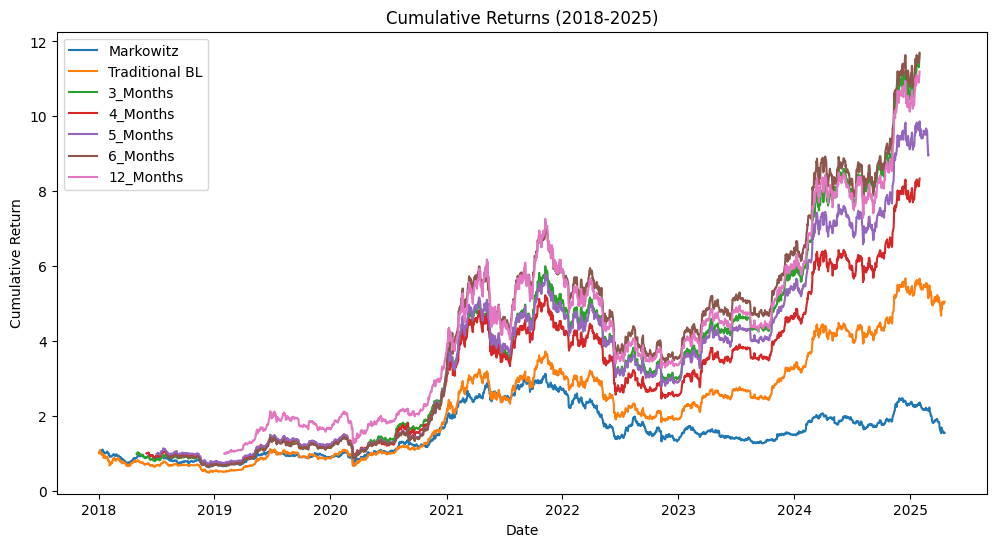

In [256]:
# Calculate cumulative returns for each portfolio
cumulative_returns_weighted = {}
cumulative_returns_weighted['Markowitz'] = (1 + returns_portfolio_3).cumprod()
cumulative_returns_weighted['Traditional BL'] = (1 + returns_portfolio1).cumprod()
cumulative_returns_weighted['3_Months'] = (1 + combined_df2).cumprod()
cumulative_returns_weighted['4_Months'] = (1 + combined_df3).cumprod()
cumulative_returns_weighted['5_Months'] = (1 + combined_df4).cumprod()
cumulative_returns_weighted['6_Months'] = (1 + combined_df5).cumprod()
cumulative_returns_weighted['12_Months'] = (1 + combined_df6).cumprod()


# Plot cumulative returns with manual weights
plt.figure(figsize=(12, 6))
for name, cumulative_return in cumulative_returns_weighted.items():
    plt.plot(cumulative_return, label=name)
plt.title('Cumulative Returns (2018-2025)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [258]:
annualized_volatility_weighted = {}
sharpe_ratio_weighted = {}
max_drawdown_weighted = {}
sortino_ratio_weighted = {}



for name, returns in cumulative_returns_weighted.items():
    # Calculate daily returns from cumulative returns
    daily_returns = returns.pct_change().dropna()

    # Annualized volatility
    vol = daily_returns.std() * np.sqrt(52)
    annualized_volatility_weighted[name] = vol

    # Sharpe Ratio (assuming risk-free rate = 0)
    sr = (daily_returns.mean() * 52) / vol
    sharpe_ratio_weighted[name] = sr

    downside_returns = daily_returns[daily_returns < 0]
    downside_std = downside_returns.std() * np.sqrt(52)
    mean_return = daily_returns.mean() * 52
    sortino_ratio = mean_return / downside_std if downside_std != 0 else np.nan
    sortino_ratio_weighted[name] = sortino_ratio

    running_max = returns.cummax()
    drawdown = (returns / running_max) - 1
    max_drawdown = drawdown.min()
    max_drawdown_weighted[name] = max_drawdown


    hits = (daily_returns > 0).sum()
    total = daily_returns.count()
    hit_ratio = hits / total if total > 0 else np.nan
    hit_ratio_weighted[name] = hit_ratio

# Print out performance metrics
for name in cumulative_returns_weighted.keys():
    print(f"{name} Performance Metrics:")
    print(f"Annualized Volatility: {annualized_volatility_weighted[name]:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio_weighted[name]:.2f}")
    print(f"Sortino Ratio: {sortino_ratio_weighted[name]:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_weighted[name]:.2%}")

    print("\n")

Markowitz Performance Metrics:
Annualized Volatility: 12.66%
Sharpe Ratio: 0.13
Sortino Ratio: 0.18
Maximum Drawdown: -59.37%
Hit Ratio: 50.39%


Traditional BL Performance Metrics:
Annualized Volatility: 14.07%
Sharpe Ratio: 0.29
Sortino Ratio: 0.38
Maximum Drawdown: -55.16%
Hit Ratio: 52.87%


3_Months Performance Metrics:
Annualized Volatility: 14.10%
Sharpe Ratio: 0.45
Sortino Ratio: 0.58
Maximum Drawdown: -52.00%
Hit Ratio: 53.32%


4_Months Performance Metrics:
Annualized Volatility: 13.90%
Sharpe Ratio: 0.40
Sortino Ratio: 0.52
Maximum Drawdown: -52.79%
Hit Ratio: 52.59%


5_Months Performance Metrics:
Annualized Volatility: 14.14%
Sharpe Ratio: 0.41
Sortino Ratio: 0.53
Maximum Drawdown: -51.75%
Hit Ratio: 52.86%


6_Months Performance Metrics:
Annualized Volatility: 14.67%
Sharpe Ratio: 0.45
Sortino Ratio: 0.58
Maximum Drawdown: -52.55%
Hit Ratio: 53.08%


12_Months Performance Metrics:
Annualized Volatility: 14.51%
Sharpe Ratio: 0.47
Sortino Ratio: 0.61
Maximum Drawdown: -54.8

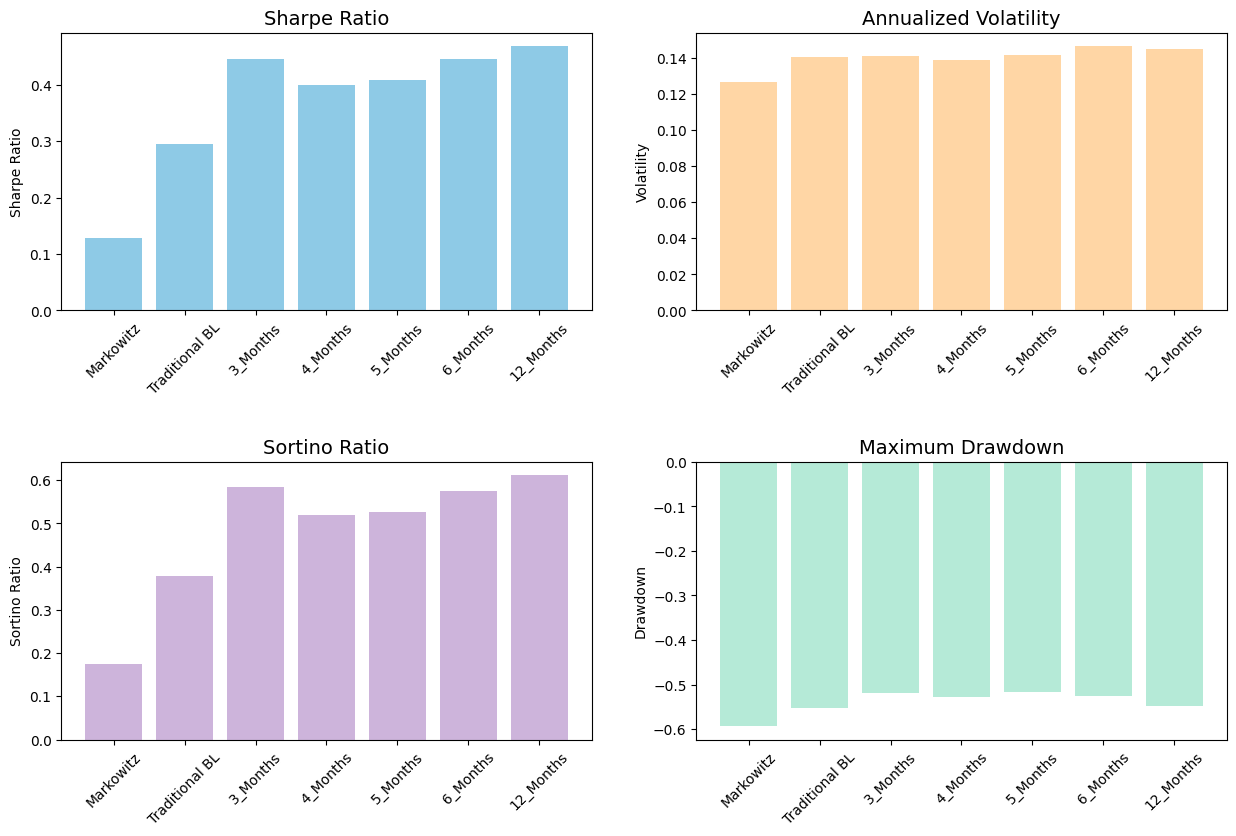

In [261]:
import matplotlib.pyplot as plt

# Collect names and metrics in lists for plotting
names = list(cumulative_returns_weighted.keys())
sharpe = [sharpe_ratio_weighted[name] for name in names]
vol = [annualized_volatility_weighted[name] for name in names]
sortino = [sortino_ratio_weighted[name] for name in names]
maxdd = [max_drawdown_weighted[name] for name in names]

# Define pastel colors
pastel_colors = ['#8ecae6', '#ffd6a5', '#cdb4db', '#b5ead7']

fig, axs = plt.subplots(2, 2, figsize=(13, 9))
axs = axs.flatten()

# Sharpe Ratio
axs[0].bar(names, sharpe, color=pastel_colors[0])
axs[0].set_title('Sharpe Ratio', fontsize=14)
axs[0].set_ylabel('Sharpe Ratio')
axs[0].tick_params(axis='x', rotation=45)

# Annualized Volatility
axs[1].bar(names, vol, color=pastel_colors[1])
axs[1].set_title('Annualized Volatility', fontsize=14)
axs[1].set_ylabel('Volatility')
axs[1].tick_params(axis='x', rotation=45)

# Sortino Ratio
axs[2].bar(names, sortino, color=pastel_colors[2])
axs[2].set_title('Sortino Ratio', fontsize=14)
axs[2].set_ylabel('Sortino Ratio')
axs[2].tick_params(axis='x', rotation=45)

# Maximum Drawdown
axs[3].bar(names, maxdd, color=pastel_colors[3])
axs[3].set_title('Maximum Drawdown', fontsize=14)
axs[3].set_ylabel('Drawdown')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout(pad=3.0)
plt.show()
